# Energy Consumption by household in the UK


In [1]:
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
import matplotlib
import os
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

import math

from sklearn import decomposition

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN

import warnings
warnings.filterwarnings('ignore')
import joblib

<ipython-input-1-5bcd47c041a9>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## PreProcessing

In [107]:
# Importing the final dataset #
weather_energy = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/weather_energy_Scenario3.csv',
                             keep_default_na=False)

In [108]:
weather_energy.columns

Index(['time', 'year', 'month', 'day', 'weekday', 'hour', 'energy(kWh/hh)',
       'visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity', 'holiday_ind',
       'weekend'],
      dtype='object')

In [109]:
weather_energy.drop('time', axis=1, inplace=True)

Using lags of upto 12 hours we are going to convert this into a supervised problem. 

In [110]:
np.random.seed(11)
dataframe = weather_energy.loc[:,'energy(kWh/hh)']
dataset = dataframe.values
dataset = dataset.astype('float32')

Next, data is reframed to work for a supervised prediction model

In [111]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Reference: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [112]:
reframed = series_to_supervised(dataset, 24,1)
reframed.head(3)

,var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
24,0.127,0.178,0.352,0.215,0.135,0.091,0.112,0.893,0.453,0.237,...,1.106,1.052,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072
25,0.178,0.352,0.215,0.135,0.091,0.112,0.893,0.453,0.237,0.283,...,1.052,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091
26,0.352,0.215,0.135,0.091,0.112,0.893,0.453,0.237,0.283,0.231,...,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091,0.054


In [113]:
# Select required columns and merge with supervised data
df = weather_energy
df = df[12:]
reframed = pd.concat([df, reframed], axis=1).dropna()
reframed

,year,month,day,weekday,hour,energy(kWh/hh),visibility,windBearing,temperature,dewPoint,...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
24,2011,11,26,5,23,0.072,13.70,232,11.59,7.18,...,1.106,1.052,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072
25,2011,11,27,6,0,0.091,14.13,229,11.98,7.98,...,1.052,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091
26,2011,11,27,6,0,0.054,14.13,229,11.98,7.98,...,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091,0.054
27,2011,11,27,6,1,0.068,13.60,233,12.08,8.28,...,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091,0.054,0.068
28,2011,11,27,6,1,0.084,13.60,233,12.08,8.28,...,0.390,0.902,0.380,0.723,0.170,0.072,0.091,0.054,0.068,0.084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39547,2014,1,30,3,2,0.080,4.78,40,4.18,2.69,...,0.341,0.085,0.827,0.070,0.720,0.198,0.322,0.115,2.586,0.080
39548,2014,2,4,1,5,0.067,13.81,225,5.63,2.26,...,0.085,0.827,0.070,0.720,0.198,0.322,0.115,2.586,0.080,0.067
39549,2014,2,9,6,17,0.406,12.15,231,6.72,-1.73,...,0.827,0.070,0.720,0.198,0.322,0.115,2.586,0.080,0.067,0.406
39550,2014,2,15,5,7,0.145,12.39,228,8.59,2.30,...,0.070,0.720,0.198,0.322,0.115,2.586,0.080,0.067,0.406,0.145


In [114]:
reframed = reframed.reindex(reframed.columns, axis=1)
reframed = reframed.values
reframed

array([[2.01100000e+03, 1.10000000e+01, 2.60000000e+01, ...,
        7.22999990e-01, 1.70000002e-01, 7.19999969e-02],
       [2.01100000e+03, 1.10000000e+01, 2.70000000e+01, ...,
        1.70000002e-01, 7.19999969e-02, 9.09999982e-02],
       [2.01100000e+03, 1.10000000e+01, 2.70000000e+01, ...,
        7.19999969e-02, 9.09999982e-02, 5.40000014e-02],
       ...,
       [2.01400000e+03, 2.00000000e+00, 9.00000000e+00, ...,
        7.99999982e-02, 6.70000017e-02, 4.05999988e-01],
       [2.01400000e+03, 2.00000000e+00, 1.50000000e+01, ...,
        6.70000017e-02, 4.05999988e-01, 1.44999996e-01],
       [2.01400000e+03, 2.00000000e+00, 1.50000000e+01, ...,
        4.05999988e-01, 1.44999996e-01, 3.47999990e-01]])

**Normalization**

The last 48 readings, corresponding to 1h, are set as the testing set, and the rest is training set

In [115]:
# split into train and test sets
train = reframed[:(len(reframed)-2), :]
test = reframed[(len(reframed)-2):len(reframed), :]

To avoid certain features on higher scales overly-affecting the model, all continous data needs to be scaled.   

In [116]:
# PreProcessing of dataset to feed to models
scaler = MinMaxScaler(feature_range=(0, 1))

Data is split between target variable and independent variables

In [117]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

The scaler must be fit on just the training set, to prevent overfitting (which means the prediction model following the trends of the training set too closely and therefore including noise in its prediction, which reduces its performance on the test set).

In [118]:
# Fit on training data and normalize it
train_X = scaler.fit_transform(train_X)

In [119]:
# Tranform the test set
test_X = scaler.transform(test_X)

In [120]:
train_X.shape

(39526, 40)

## Household energy models

Models are created separately. Lists are held with their performances, so a dataframe can be plotted at the end to compare them.

In [121]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [122]:
R2_scores = []
MSE_scores = []
RMSE_scores = []
MAE_scores = []
MAPE_scores = []
train_times = []
models_predictions = ['MLR', 'SVM', 'RF', 'FFNNs', 'LSTM', 'RNN', 'Dense+LSTM']

### multiple linear regression (MLR)

The model is fit on the training set.

In [123]:
from sklearn import linear_model
import time
model = linear_model.LinearRegression()
start_time = time.time()
model.fit(train_X, train_y)
end_time = time.time()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)
model.coef_

Training time: 0.042 s


array([ 2.73275790e-10,  3.29336202e-10, -2.38463700e-11,  7.57980296e-11,
        3.71786756e-10,  4.89500000e+00, -3.51515478e-10,  2.38913278e-11,
       -1.06593616e-09,  2.06567178e-09, -3.55794447e-10, -1.01724739e-09,
       -5.59736269e-11, -1.40453572e-09, -2.53838194e-09, -6.86060087e-11,
       -4.24886393e-12, -1.58651695e-09,  1.41481490e-10,  1.84863429e-09,
       -1.21264543e-09, -1.99279733e-09,  1.13361662e-09,  2.50657077e-09,
        5.91420375e-10, -1.68863494e-09, -2.21982394e-10, -6.89934476e-10,
       -2.96696790e-10, -4.77865332e-10,  1.73756968e-09,  1.74990568e-09,
        1.41714463e-09,  1.39080307e-10, -7.10447220e-10, -1.42129651e-10,
       -1.74154843e-09,  3.95528930e-09,  2.44153630e-09,  2.21332407e-09])

A prediction is made on the test set.

In [124]:
# make a prediction
yhat = model.predict(test_X)

In [125]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

Then, the prediction is compared to the true target feature values, and the model's performance is calculated. 

In [126]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999999999999995
Mse:  0.000000000000000
Rmse: 0.000000007471664
Mae:  0.000000006765354
Mape:  0.000002667052819
Training time: 0.042 s


In [127]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

In [128]:
import matplotlib
import seaborn as sns

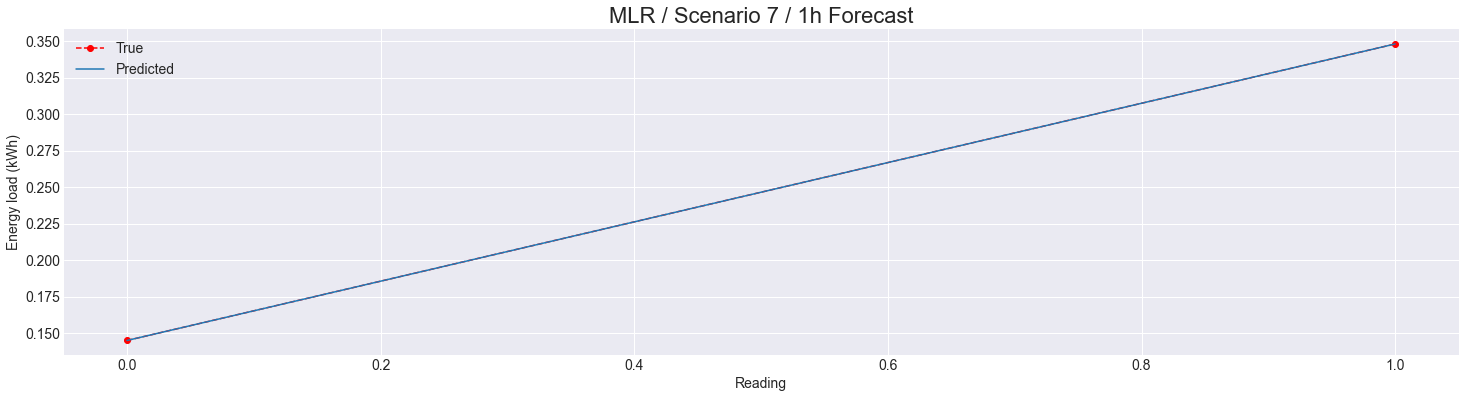

In [129]:
matplotlib.rcParams.update({'font.size': 14})
predicted_mreg = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_mreg['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_mreg['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('MLR / Scenario 7 / 1h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario7/1_allHouseholds/S7_1h_MLR.jpeg', dpi = 500)
plt.show()


The model is predicting almost perfectly.

In [130]:
from joblib import dump, load
dump(model, 'C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/MLR_Scenario3.joblib')

['C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/MLR_Scenario3.joblib']

### support vector regressor (SVR)

In [131]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR

In [132]:
model = LinearSVR(C=8, 
                  dual=False, 
                  epsilon=0.001, loss='squared_epsilon_insensitive') 
start_time = time.time()
model.fit(train_X, train_y)
end_time = time.time()
train_time = end_time - start_time
train_times.append(train_time)
print(f'Training time: {train_time:.3f} s') 

Training time: 0.200 s


**Prediction**

In [133]:
# make a prediction
yhat = model.predict(test_X)

In [134]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999999774094703
Mse:  0.000000002325371
Rmse: 0.000048222098648
Mae:  0.000042790731439
Mape:  0.025365878681024
Training time: 0.200 s


In [135]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

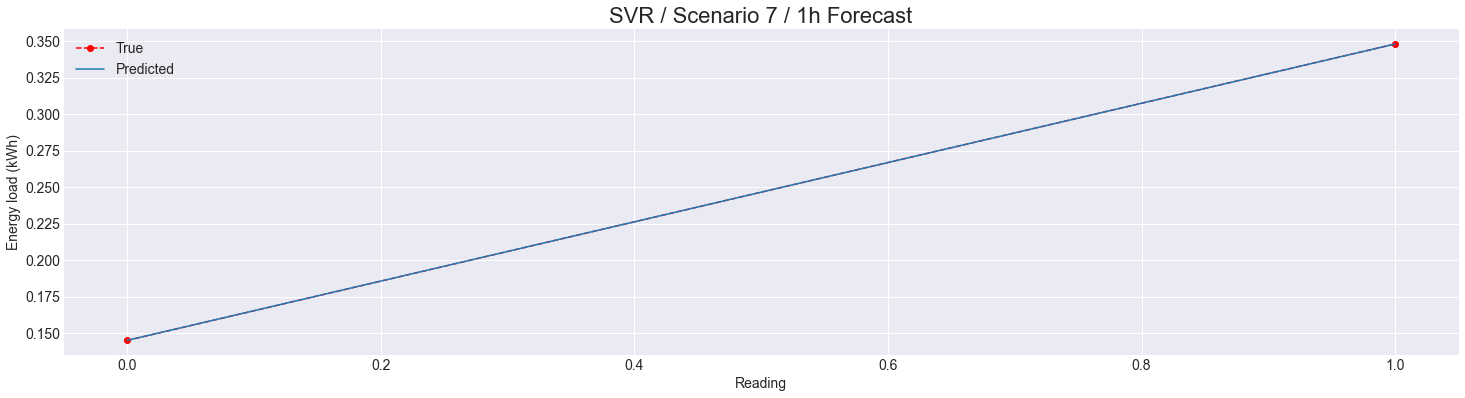

In [136]:
matplotlib.rcParams.update({'font.size': 14})
predicted_svm = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_svm['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_svm['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('SVR / Scenario 7 / 1h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario7/1_allHouseholds/S7_1h_SVR.jpeg', dpi = 500)
plt.show()

Although the model picked up on the general trend, it clearly lacks the performance of the MLR.

In [137]:
from joblib import dump, load
dump(model, 'C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/SVR_Scenario3.joblib')

['C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/SVR_Scenario3.joblib']

### random forest (RF)

In [138]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [139]:
model = RandomForestRegressor(bootstrap= True,
                              max_depth= 110,
                              max_features= 0.33,
                              min_samples_leaf= 3,
                              min_samples_split= 10,
                              n_estimators= 100, 
                              criterion='mse')
start_time = time.time()
model.fit(train_X, train_y)
end_time = time.time()
train_time = end_time - start_time
train_times.append(train_time)
print(f'Training time: {train_time:.3f} s') 

Training time: 23.640 s


**Prediction**

In [140]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.reshape(yhat.shape[0],1)

**Prediction**

In [141]:
# make a prediction
yhat = model.predict(test_X)

In [142]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.997448544211687
Mse:  0.000026045738198
Rmse: 0.005103502542207
Mae:  0.005082327136363
Mape:  2.497004867856828
Training time: 23.640 s


In [143]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

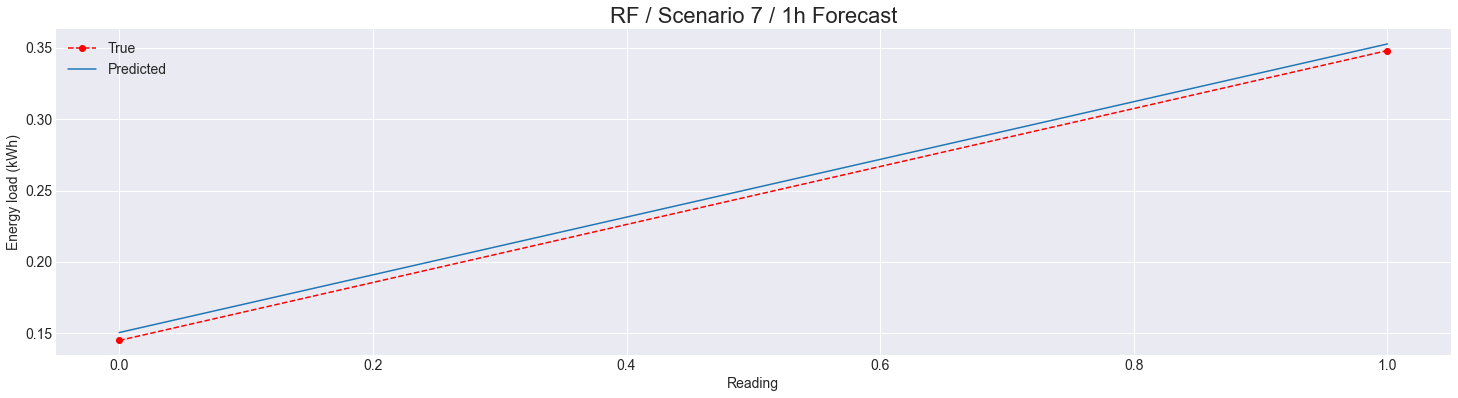

In [144]:
matplotlib.rcParams.update({'font.size': 14})
predicted_rf = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_rf['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_rf['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('RF / Scenario 7 / 1h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario7/1_allHouseholds/S7_1h_RF.jpeg', dpi = 500)
plt.show()

The model is predicting very well, picking up on very fine energy consumption trends

### feedforward neural networks (FFNNs)

Data must be reshaped for the neural networks models to work

In [145]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(39526, 1, 40) (39526,) (2, 1, 40) (2,)


In [146]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution1D, MaxPooling1D
from keras.layers.convolutional import Conv2D, Conv1D
from keras.layers import GRU
from keras.layers.convolutional import MaxPooling2D
from keras.layers.embeddings import Embedding
from keras.layers import TimeDistributed
import keras
from keras import layers

In [147]:
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.datasets import mnist
from keras.models import Sequential
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [148]:
# Load libraries
import numpy as np
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

# Set random seed

import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

import time

In [149]:
from keras.optimizers import RMSprop

Epoch 1/10
7906/7906 - 5s - loss: 0.0081
Epoch 2/10
7906/7906 - 5s - loss: 7.6503e-04
Epoch 3/10
7906/7906 - 6s - loss: 4.4339e-04
Epoch 4/10
7906/7906 - 4s - loss: 3.0757e-04
Epoch 5/10
7906/7906 - 5s - loss: 2.4238e-04
Epoch 6/10
7906/7906 - 5s - loss: 2.0701e-04
Epoch 7/10
7906/7906 - 5s - loss: 1.7604e-04
Epoch 8/10
7906/7906 - 5s - loss: 1.5575e-04
Epoch 9/10
7906/7906 - 4s - loss: 1.4378e-04
Epoch 10/10
7906/7906 - 4s - loss: 1.3357e-04


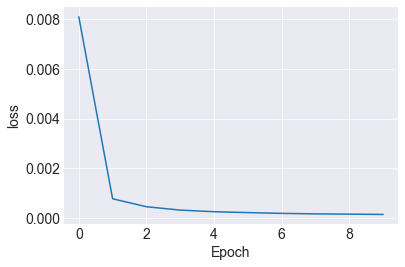

Training time: 47.848 s


In [150]:
model = Sequential()

# Add fully connected layer with a ReLU activation function
model.add(Dense(units=64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(units=64, activation='relu'))

# Add fully connected layer with no activation function
model.add(Dense(units=1))

optimizer = keras.optimizers.RMSprop(lr=0.001, momentum= 0.9)

model.compile(loss='mean_squared_error', # Mean squared error
            optimizer ='RMSprop' # Optimization algorithm
            )

start_time = time.time()
history = model.fit(train_X, train_y, epochs=10, batch_size=5, verbose=2, shuffle=False) 
end_time = time.time()
train_time = end_time - start_time
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

**Prediction**

In [151]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [152]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.918462729606145
Mse:  0.000850037850983
Rmse: 0.029155408606004
Mae:  0.029149159789085
Mape:  17.376092886697446
Training time: 47.848 s


In [153]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

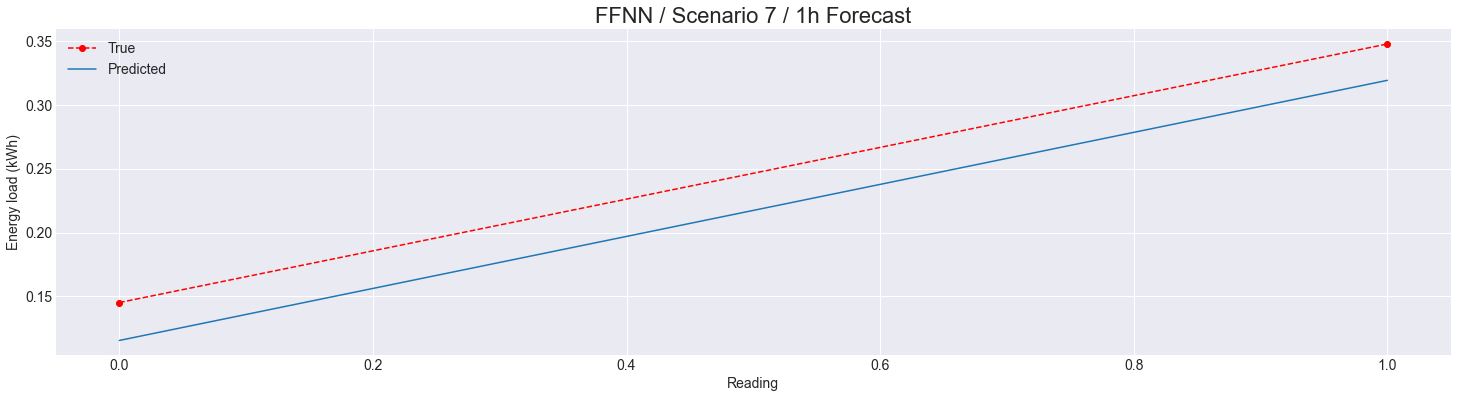

In [154]:
matplotlib.rcParams.update({'font.size': 14})
predicted_fnn = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_fnn['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_fnn['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('FFNN / Scenario 7 / 1h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario7/1_allHouseholds/S7_1h_FFNN.jpeg', dpi = 500)
plt.show()

Good predictions, although a bit worse compared to the RF.

### LSTM

In [155]:
from keras.wrappers.scikit_learn import KerasRegressor
# Load libraries
import numpy as np
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

# Set random seed

import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

import time

In [156]:
from keras.optimizers import Adam

Epoch 1/30
1647/1647 - 2s - loss: 0.0478
Epoch 2/30
1647/1647 - 2s - loss: 0.0023
Epoch 3/30
1647/1647 - 2s - loss: 3.4950e-04
Epoch 4/30
1647/1647 - 2s - loss: 2.2979e-04
Epoch 5/30
1647/1647 - 2s - loss: 3.5419e-04
Epoch 6/30
1647/1647 - 2s - loss: 2.7596e-04
Epoch 7/30
1647/1647 - 2s - loss: 2.2352e-04
Epoch 8/30
1647/1647 - 2s - loss: 2.8474e-04
Epoch 9/30
1647/1647 - 2s - loss: 2.4524e-04
Epoch 10/30
1647/1647 - 2s - loss: 3.1546e-04
Epoch 11/30
1647/1647 - 2s - loss: 1.9901e-04
Epoch 12/30
1647/1647 - 2s - loss: 4.5195e-04
Epoch 13/30
1647/1647 - 2s - loss: 6.6277e-05
Epoch 14/30
1647/1647 - 2s - loss: 1.9652e-04
Epoch 15/30
1647/1647 - 2s - loss: 3.7881e-04
Epoch 16/30
1647/1647 - 2s - loss: 1.2751e-04
Epoch 17/30
1647/1647 - 2s - loss: 1.8866e-04
Epoch 18/30
1647/1647 - 2s - loss: 2.0439e-04
Epoch 19/30
1647/1647 - 2s - loss: 1.3166e-04
Epoch 20/30
1647/1647 - 2s - loss: 2.0098e-04
Epoch 21/30
1647/1647 - 2s - loss: 2.1167e-04
Epoch 22/30
1647/1647 - 2s - loss: 2.2948e-04
Epoch

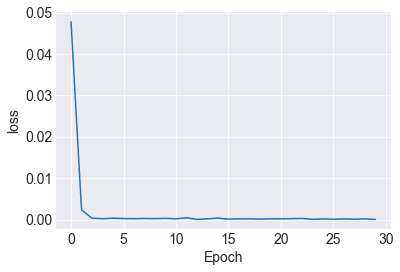

Training time: 59.301 s


In [157]:
# design network
model = Sequential()
model.add(LSTM(128,  activation='softplus', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

optimizer = Adam(lr=0.001)

model.compile(loss='mean_squared_error', # Mean squared error
             optimizer = optimizer # Optimization algorithm
            )


start_time = time.time()
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=24, verbose=2, shuffle=False)
end_time = time.time()
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

**Prediction**

In [158]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [159]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.996334835609925
Mse:  0.000038753773803
Rmse: 0.006225252910759
Mae:  0.006082013249397
Mape:  2.629782555835956
Training time: 59.301 s


In [160]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

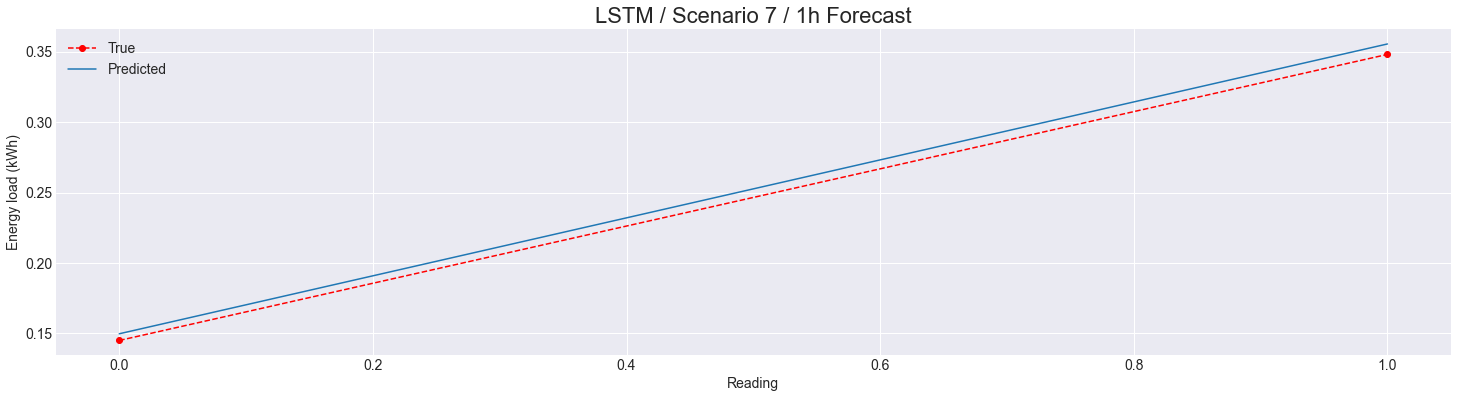

In [161]:
matplotlib.rcParams.update({'font.size': 14})
predicted_lstm = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_lstm['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_lstm['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('LSTM / Scenario 7 / 1h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario7/1_allHouseholds/S7_1h_LSTM.jpeg', dpi = 500)
plt.show()

The model is doing well, better than the previous NN, however not as good as MLR and RF.

### RNN

In [162]:
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.datasets import mnist
from keras.models import Sequential
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

Epoch 1/30
1647/1647 - 1s - loss: 0.0230
Epoch 2/30
1647/1647 - 1s - loss: 3.1188e-04
Epoch 3/30
1647/1647 - 1s - loss: 6.0151e-04
Epoch 4/30
1647/1647 - 1s - loss: 0.0011
Epoch 5/30
1647/1647 - 1s - loss: 7.9515e-04
Epoch 6/30
1647/1647 - 2s - loss: 2.9632e-04
Epoch 7/30
1647/1647 - 1s - loss: 7.1953e-04
Epoch 8/30
1647/1647 - 1s - loss: 3.8352e-04
Epoch 9/30
1647/1647 - 1s - loss: 6.4088e-04
Epoch 10/30
1647/1647 - 1s - loss: 2.6706e-04
Epoch 11/30
1647/1647 - 1s - loss: 5.4982e-04
Epoch 12/30
1647/1647 - 1s - loss: 1.9243e-04
Epoch 13/30
1647/1647 - 1s - loss: 2.6614e-04
Epoch 14/30
1647/1647 - 1s - loss: 3.2740e-04
Epoch 15/30
1647/1647 - 1s - loss: 2.6872e-04
Epoch 16/30
1647/1647 - 1s - loss: 1.4334e-04
Epoch 17/30
1647/1647 - 1s - loss: 2.6335e-04
Epoch 18/30
1647/1647 - 1s - loss: 8.1345e-05
Epoch 19/30
1647/1647 - 1s - loss: 2.7692e-04
Epoch 20/30
1647/1647 - 2s - loss: 1.0870e-04
Epoch 21/30
1647/1647 - 1s - loss: 1.3524e-04
Epoch 22/30
1647/1647 - 1s - loss: 1.1837e-04
Epoch

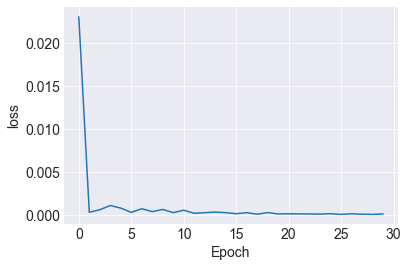

Training time: 40.658 s


In [163]:
# design network
model = Sequential()
model.add(SimpleRNN(128, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

optimizer = Adam(lr=0.001)

model.compile(loss='mean_squared_error', # Mean squared error
             optimizer = optimizer # Optimization algorithm
            )


start_time = time.time()
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=24, verbose=2, shuffle=False)
end_time = time.time()
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

In [164]:
model.save('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/RNN_Scenario3.h5')

In [165]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/RNN_Scenario3.h5")
print("Saved model to disk")
 

Saved model to disk


In [166]:
from keras.models import model_from_json


In [167]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/RNN_Scenario3.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data


Loaded model from disk


**Prediction**

In [168]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [169]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999772476648610
Mse:  0.000002352123062
Rmse: 0.001533663281851
Mae:  0.001523569226265
Mape:  0.787309294776723
Training time: 40.658 s


In [170]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

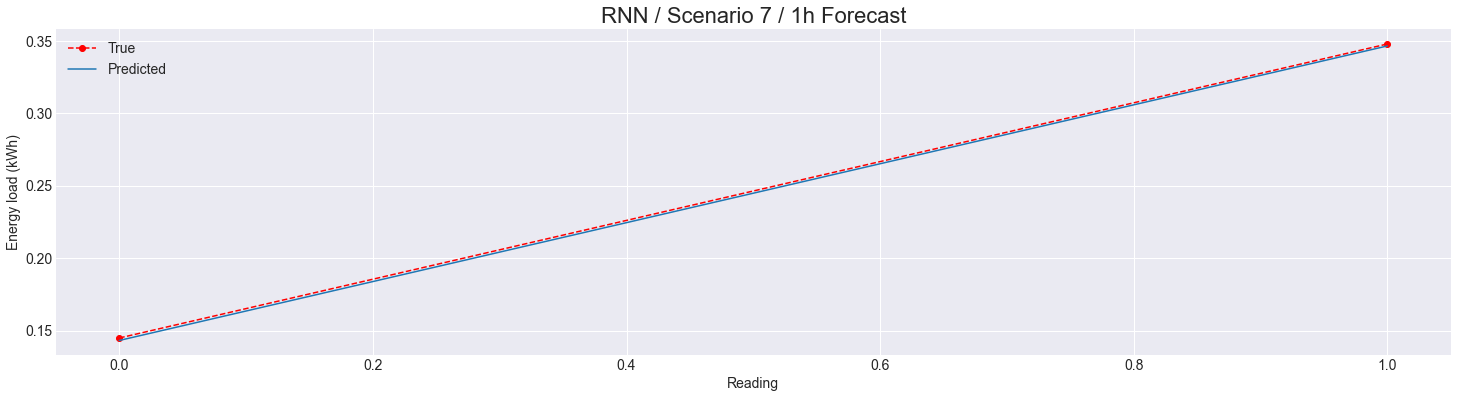

In [171]:
matplotlib.rcParams.update({'font.size': 14})
predicted_rnn = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_rnn['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_rnn['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('RNN / Scenario 7 / 1h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario7/1_allHouseholds/S7_1h_RNN.jpeg', dpi = 500)
plt.show()

The model is doing well however its accuracy is worse than that of CNN-LSTM. However, it's training 4 times faster. 

Because this model achieved the best performance, saving it:

### Dense + LSTM

Epoch 1/30
618/618 - 1s - loss: 0.0799
Epoch 2/30
618/618 - 1s - loss: 0.0215
Epoch 3/30
618/618 - 1s - loss: 0.0015
Epoch 4/30
618/618 - 1s - loss: 9.5760e-04
Epoch 5/30
618/618 - 1s - loss: 8.3181e-04
Epoch 6/30
618/618 - 1s - loss: 7.1609e-04
Epoch 7/30
618/618 - 1s - loss: 6.0638e-04
Epoch 8/30
618/618 - 1s - loss: 5.0176e-04
Epoch 9/30
618/618 - 1s - loss: 4.2667e-04
Epoch 10/30
618/618 - 1s - loss: 4.1954e-04
Epoch 11/30
618/618 - 1s - loss: 3.8519e-04
Epoch 12/30
618/618 - 1s - loss: 3.2998e-04
Epoch 13/30
618/618 - 1s - loss: 2.6582e-04
Epoch 14/30
618/618 - 1s - loss: 5.9241e-04
Epoch 15/30
618/618 - 1s - loss: 1.9252e-04
Epoch 16/30
618/618 - 1s - loss: 2.0233e-04
Epoch 17/30
618/618 - 1s - loss: 4.3815e-04
Epoch 18/30
618/618 - 1s - loss: 1.6008e-04
Epoch 19/30
618/618 - 1s - loss: 3.0613e-04
Epoch 20/30
618/618 - 1s - loss: 1.4598e-04
Epoch 21/30
618/618 - 1s - loss: 3.3262e-04
Epoch 22/30
618/618 - 1s - loss: 1.2642e-04
Epoch 23/30
618/618 - 1s - loss: 2.7316e-04
Epoch 24/

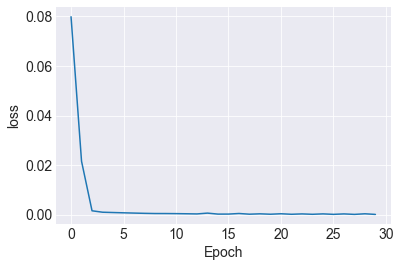

Training time: 35.173 s


In [172]:
# design network
model = Sequential()
model.add(Dense(256,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(LSTM(128))
model.add(Dense(1))
optimizer = Adam(lr=0.0001)

model.compile(loss='mean_squared_error', # Mean squared error
             optimizer = optimizer # Optimization algorithm
            )

#model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc']) #mae

start_time = time.time()
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=64, verbose=2, shuffle=False)
end_time = time.time()
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

In [173]:
model.save('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/dense_LSTM_Scenario3_1h.h5')

**Prediction**

In [174]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [175]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.966296248638411
Mse:  0.000337296622810
Rmse: 0.018365637010730
Mae:  0.018307387828827
Mape:  8.307614485177172
Training time: 35.173 s


In [176]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

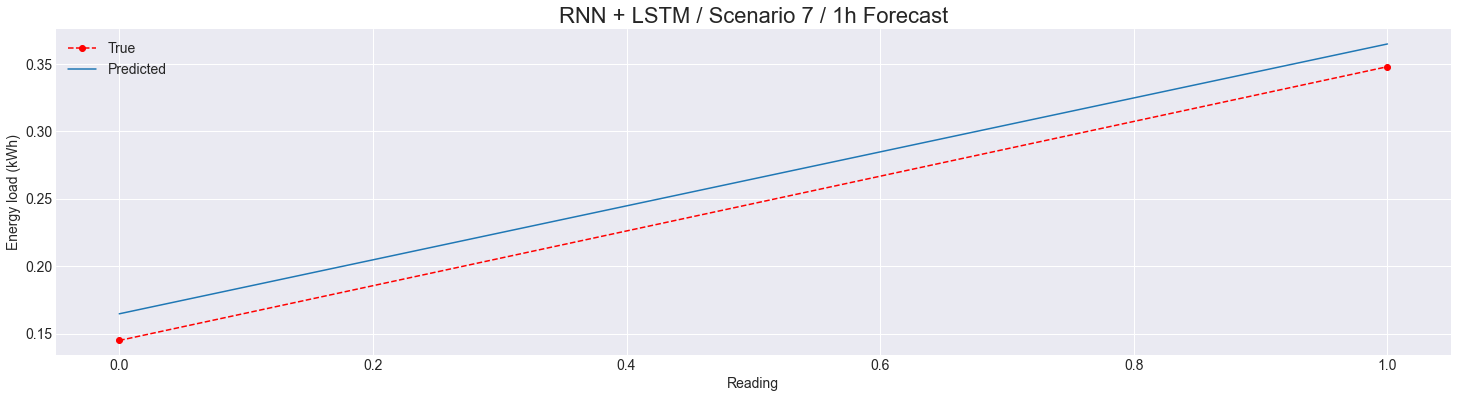

In [177]:
matplotlib.rcParams.update({'font.size': 14})
predicted_denselstm = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_denselstm['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_denselstm['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('RNN + LSTM / Scenario 7 / 1h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario7/1_allHouseholds/S7_1h_RNN_LSTM.jpeg', dpi = 500)
plt.show()

This is the best model, the predictions accurately follow the observed energy consumption.


## Best model

In [ ]:
models_performances = pd.DataFrame([R2_scores,MSE_scores,RMSE_scores,MAE_scores,MAPE_scores,train_times],
                                   columns=models_predictions, 
                                   index=['R2_scores', 'MSE_scores', 'RMSE_scores',
                                          'MAE_scores', 'MAPE_scores', 'Train_Time'])
models_performances

,MLR,SVM,RF,FFNNs,LSTM,RNN,Dense+LSTM
R2_scores,1.000000e+00,9.999998e-01,0.997449,0.878512,0.985540,0.999440,0.993438
MSE_scores,5.582577e-17,2.325371e-09,0.000026,0.001139,0.000147,0.000006,0.000066
RMSE_scores,7.471664e-09,4.822210e-05,0.005104,0.033753,0.012143,0.002405,0.008106
MAE_scores,6.765354e-09,4.279073e-05,0.005082,0.033430,0.012132,0.002401,0.007978
MAPE_scores,2.667053e-06,2.536588e-02,2.497005,18.521041,6.238893,1.132934,3.753434
Train_Time,5.684853e-02,2.792540e-01,31.228565,58.521060,53.538391,36.731112,35.150546


In [ ]:
models_performances.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/model_performance/BestModel_Scenario3_1h.csv', index=False)

Most models are returning similar scores, except for the SVM, which is significantly under-performing. 

The best performance, in terms of all the metrics measured except for training time, is the neural network with dense layers combined with LSTM.

**Plotting all models together.**

In [ ]:
prev_day = train_y[-2:] #energy readings from previous day
y_plotting = np.concatenate([prev_day, test_y], axis=0)

In [ ]:

# Get all predictions from the models
predicted_energy=[predicted_mreg['predicted'],
                  predicted_svm['predicted'],
                  predicted_rf['predicted'],
                  predicted_fnn['predicted'],
                  predicted_lstm['predicted'],
                  predicted_rnn['predicted'],
                  predicted_denselstm['predicted']]

In [ ]:
prev_2days = sorted(pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/weather_energy_Scenario3.csv').time)[-4:]

In [ ]:
prev_2days

['2014-02-26 00:30:00',
 '2014-02-26 01:00:00',
 '2014-02-26 01:30:00',
 '2014-02-26 02:00:00',
 '2014-02-26 02:30:00',
 '2014-02-26 03:00:00',
 '2014-02-26 03:30:00',
 '2014-02-26 04:00:00',
 '2014-02-26 04:30:00',
 '2014-02-26 05:00:00',
 '2014-02-26 05:30:00',
 '2014-02-26 06:00:00',
 '2014-02-26 06:30:00',
 '2014-02-26 07:00:00',
 '2014-02-26 07:30:00',
 '2014-02-26 08:00:00',
 '2014-02-26 08:30:00',
 '2014-02-26 09:00:00',
 '2014-02-26 09:30:00',
 '2014-02-26 10:00:00',
 '2014-02-26 10:30:00',
 '2014-02-26 11:00:00',
 '2014-02-26 11:30:00',
 '2014-02-26 12:00:00',
 '2014-02-26 12:30:00',
 '2014-02-26 13:00:00',
 '2014-02-26 13:30:00',
 '2014-02-26 14:00:00',
 '2014-02-26 14:30:00',
 '2014-02-26 15:00:00',
 '2014-02-26 15:30:00',
 '2014-02-26 16:00:00',
 '2014-02-26 16:30:00',
 '2014-02-26 17:00:00',
 '2014-02-26 17:30:00',
 '2014-02-26 18:00:00',
 '2014-02-26 18:30:00',
 '2014-02-26 19:00:00',
 '2014-02-26 19:30:00',
 '2014-02-26 20:00:00',
 '2014-02-26 20:30:00',
 '2014-02-26 21:

In [ ]:
df_for_plotting = pd.DataFrame(y_plotting, index=prev_2days, columns=['Original'])

In [ ]:
# Initialize all columns with null values
df_for_plotting["Train"] = np.nan
# Add a column for each model's predictions
col_names=['MLR', 'SVR', 'RF', 'FFNN', 'LSTM', 'RNN', 'Dense-LSTM']
for col_name in col_names:
  df_for_plotting[col_name+' forecast'] = np.nan

In [ ]:
# Fill in with corresponding values
df_for_plotting["Train"][:-48] = prev_day

for i, model_pred in enumerate(predicted_energy):
  df_for_plotting[col_names[i]+' forecast'][-48:] = model_pred

In [ ]:
# Turn index to datetime
df_for_plotting.index = pd.to_datetime(df_for_plotting.index)

In [ ]:
df_for_plotting.columns

Index(['Original', 'Train', 'MLR forecast', 'SVR forecast', 'RF forecast',
       'FFNN forecast', 'LSTM forecast', 'RNN forecast',
       'Dense-LSTM forecast'],
      dtype='object')

In [ ]:
import datetime
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt

## House level prediction 
-For each half hour, for each of the 33 types.

In [178]:
houses_data = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/all_houses_Scenario4.csv')

In [179]:
houses_data

,LCLid,tstp,energy(kWh/hh)
0,2,2012-10-12 00:30:00,0.000
1,2,2012-10-12 01:00:00,0.000
2,2,2012-10-12 01:30:00,0.000
3,2,2012-10-12 02:00:00,0.000
4,2,2012-10-12 02:30:00,0.000
...,...,...,...
8092712,5124,2014-02-27 22:00:00,0.673
8092713,5124,2014-02-27 22:30:00,0.590
8092714,5124,2014-02-27 23:00:00,0.552
8092715,5124,2014-02-27 23:30:00,0.519


In [180]:
houses_data.rename(columns={'tstp':'time'}, inplace=True)

Merging with the weather_energy data

In [181]:
weather_energy = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/weather_energy_Scenario4.csv')

In [182]:
weather_energy.columns

Index(['time', 'year', 'month', 'day', 'hour', 'weekday', 'energy(kWh/hh)',
       'visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity', 'holiday_ind',
       'stdorToU', 'Acorn', 'Acorn_grouped', 'weekend'],
      dtype='object')

In [183]:
weather_energy = weather_energy.drop(columns = ['stdorToU', 'Acorn', 'Acorn_grouped'])

In [184]:
updated_houses = houses_data.merge(weather_energy, on='time')

In [185]:
updated_houses

,LCLid,time,energy(kWh/hh)_x,year,month,day,hour,weekday,energy(kWh/hh)_y,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,holiday_ind,weekend
0,2,2012-10-12 00:30:00,0.000,2012,10,12,0,4,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91,0,0
1,246,2012-10-12 00:30:00,0.975,2012,10,12,0,4,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91,0,0
2,1074,2012-10-12 00:30:00,1.438,2012,10,12,0,4,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91,0,0
3,3281,2012-10-12 00:30:00,0.078,2012,10,12,0,4,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91,0,0
4,3305,2012-10-12 00:30:00,0.101,2012,10,12,0,4,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8086036,183,2011-12-03 06:30:00,0.109,2011,12,3,6,5,0.109,11.73,244,11.00,10.26,1001.07,11.00,6.37,0.95,0,1
8086037,183,2011-12-03 07:00:00,0.030,2011,12,3,7,5,0.030,11.93,253,10.96,9.73,1001.07,10.96,5.48,0.92,0,1
8086038,183,2011-12-03 07:30:00,0.082,2011,12,3,7,5,0.082,11.93,253,10.96,9.73,1001.07,10.96,5.48,0.92,0,1
8086039,183,2011-12-03 08:00:00,0.030,2011,12,3,8,5,0.030,13.71,253,11.01,9.11,1001.55,11.01,6.32,0.88,0,1


In [186]:
updated_houses.columns

Index(['LCLid', 'time', 'energy(kWh/hh)_x', 'year', 'month', 'day', 'hour',
       'weekday', 'energy(kWh/hh)_y', 'visibility', 'windBearing',
       'temperature', 'dewPoint', 'pressure', 'apparentTemperature',
       'windSpeed', 'humidity', 'holiday_ind', 'weekend'],
      dtype='object')

In [187]:
updated_houses.columns = ['LCLid', 'time', 'energy(kWh/hh)', 'year', 'month', 'day', 'hour',
       'weekday', 'energy(kWh/hh)_y', 'visibility', 'windBearing',
       'temperature', 'dewPoint', 'pressure', 'apparentTemperature',
       'windSpeed', 'humidity', 'holiday_ind', 'weekend']

In [188]:
updated_houses.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/updated_houses_S3.csv')

In [189]:
updated_houses = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/updated_houses_S3.csv')

In [190]:
updated_houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8086041 entries, 0 to 8086040
Data columns (total 20 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Unnamed: 0           int64  
 1   LCLid                int64  
 2   time                 object 
 3   energy(kWh/hh)       float64
 4   year                 int64  
 5   month                int64  
 6   day                  int64  
 7   hour                 int64  
 8   weekday              int64  
 9   energy(kWh/hh)_y     float64
 10  visibility           float64
 11  windBearing          int64  
 12  temperature          float64
 13  dewPoint             float64
 14  pressure             float64
 15  apparentTemperature  float64
 16  windSpeed            float64
 17  humidity             float64
 18  holiday_ind          int64  
 19  weekend              int64  
dtypes: float64(9), int64(10), object(1)
memory usage: 1.2+ GB


Function to check another household:

In [191]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [192]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [193]:
from keras.models import Sequential, load_model
from joblib import dump, load


In [194]:
MSE_scores_HH = []
RMSE_scores_HH = []
MAE_scores_HH = []
MAPE_scores_HH = []
households_predictions = ['HH_1',
                      'HH_2',
                      'HH_3',
                      'HH_4',
                      'HH_5',
                      'HH_6',
                      'HH_7',
                      'HH_8',
                      'HH_9',
                      'HH_10',
                      'HH_11',
                      'HH_12',
                      'HH_13',
                      'HH_14',
                      'HH_15',
                      'HH_16',
                      'HH_17',
                      'HH_18',
                      'HH_19',
                      'HH_20',
                      'HH_21',
                      'HH_22',
                      'HH_23',
                      'HH_24',
                      'HH_25',
                      'HH_26',
                      'HH_27',
                      'HH_28', 
                      'HH_29']

In [195]:
from keras.optimizers import Adam

In [196]:
# tune the Rf parametersbegining with house numbber of your choice 
def predict_household_AfterTuning(num):
  house = updated_houses[updated_houses.LCLid==num]

  np.random.seed(5)
  dataframe = house.loc[:,'energy(kWh/hh)']
  dataset = dataframe.values
  dataset = dataset.astype('float32')

  reframed = series_to_supervised(dataset, 24,1)

  # Select required columns and merge with supervised data
  df=house[weather_energy.columns[1:]]
  df = df[12:]
  reframed = pd.concat([df, reframed], axis=1).dropna()

  reframed = reframed.reindex(reframed.columns, axis=1)
  reframed = reframed.values

  # split into train and test sets''''
  train = reframed[:(len(reframed)-2), :]
  test = reframed[(len(reframed)-2):len(reframed), :]

  #test_X, labels = test[:, :-1], test[:, -1]
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  
  # Tranform the test set
  #train_X = scaler.fit_transform(train_X)
  #test_X = scaler.transform(test_X)

  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

  model = Sequential()
  model.add(SimpleRNN(128, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(1))

  optimizer = Adam(lr=0.001)

  model.compile(loss='mean_squared_error', # Mean squared error
              optimizer = optimizer # Optimization algorithm
              )


  predicted = model.predict(test_X)

  mse_HH = mean_squared_error(predicted,test_y.ravel())
  rmse_HH = mean_squared_error(predicted,test_y.ravel(), squared=False)
  mae_HH = mean_absolute_error(predicted,test_y.ravel())
  mape_HH = mean_absolute_percentage_error(predicted, test_y.ravel())

  print(f'Mse:  {mse_HH:.15f}')
  print(f'Rmse: {rmse_HH:.15f}')
  print(f'Mae:  {mae_HH:.15f}')
  print(f'Mape:  {mape_HH:.15f}')
  #print(f'Training time: {train_time_HH:.3f} s') 

  MSE_scores_HH.append(mse_HH)
  RMSE_scores_HH.append(rmse_HH)
  MAE_scores_HH.append(mae_HH)
  MAPE_scores_HH.append(mape_HH)
#  train_times_HH.append(train_time)

  matplotlib.rcParams.update({'font.size': 16})
  predicted_house = pd.DataFrame({'Predicted':predicted.ravel(),'True Reading':test_y.ravel()})
  predicted_house['True Reading'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
  predicted_house['Predicted'].plot()
  plt.title(f'House {num} Prediction /RNN (Scenario 7)')
  plt.xlabel('Reading')
  plt.ylabel('Energy (kWh)')
  # style

  plt.style.use('seaborn-darkgrid')
  palette = plt.get_cmap('Set1')

  plt.grid(b=True, which='major', color='w', linewidth=1.0)
  plt.legend(['True','Predicted'])
  plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario7/2_singleHouseholdLevel/best_NN_model/S7_1h_RNN_HH'+str(num) + '.jpeg', dpi = 500)
  plt.show()


Mse:  9383.990438797238312
Rmse: 96.870998956329743
Mae:  96.870998110622168
Mape:  100.128686836007603


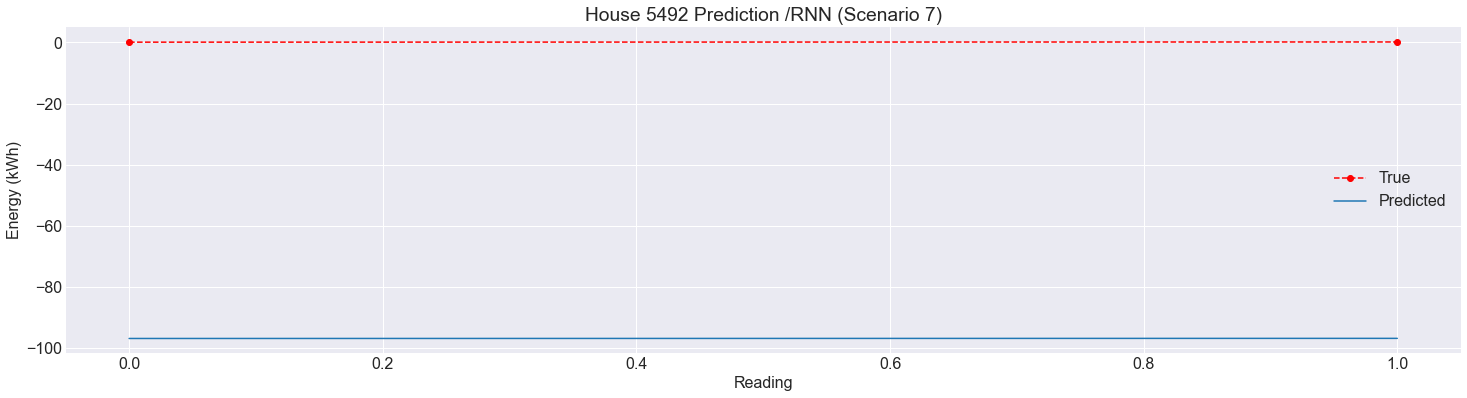

Mse:  45656.492211077755201
Rmse: 213.673798606843121
Mae:  213.673277590423822
Mape:  99.927511510221677


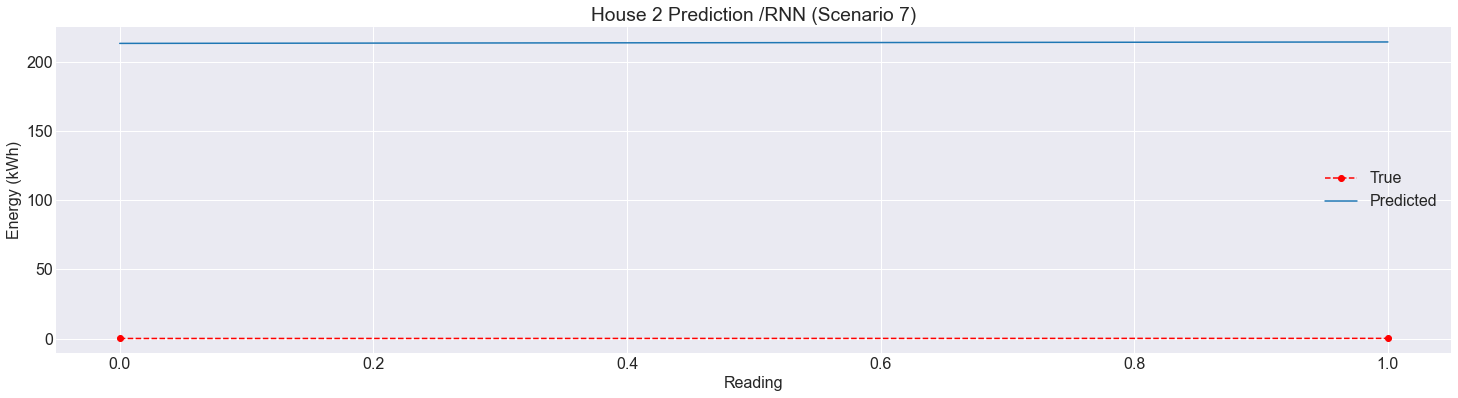

Mse:  23963.121626277548785
Rmse: 154.800263650542746
Mae:  154.800238415598869
Mape:  99.788240183137759


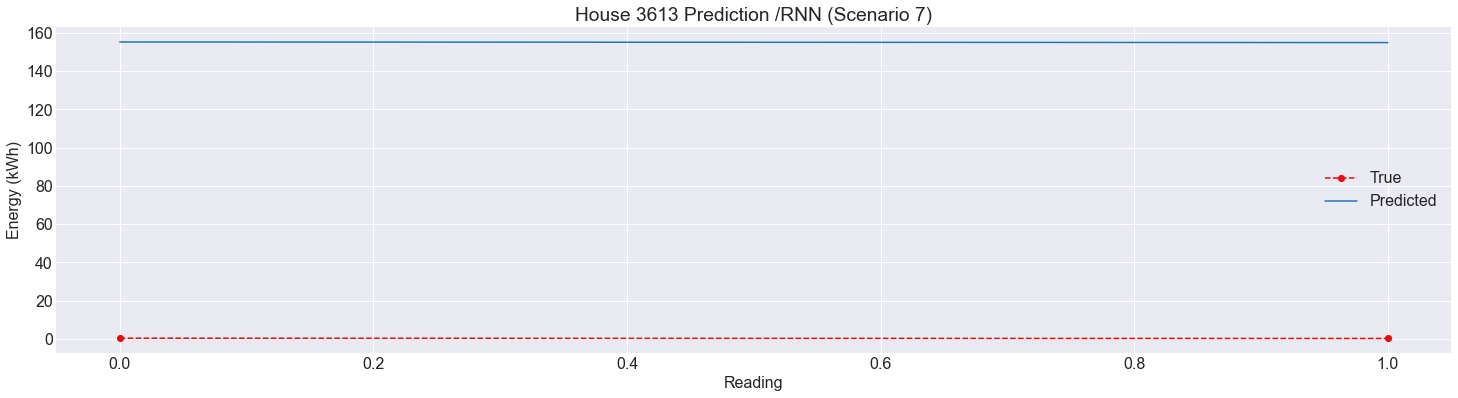

Mse:  636.342963114453596
Rmse: 25.225839195445086
Mae:  25.225729405879974
Mape:  99.387342464069917


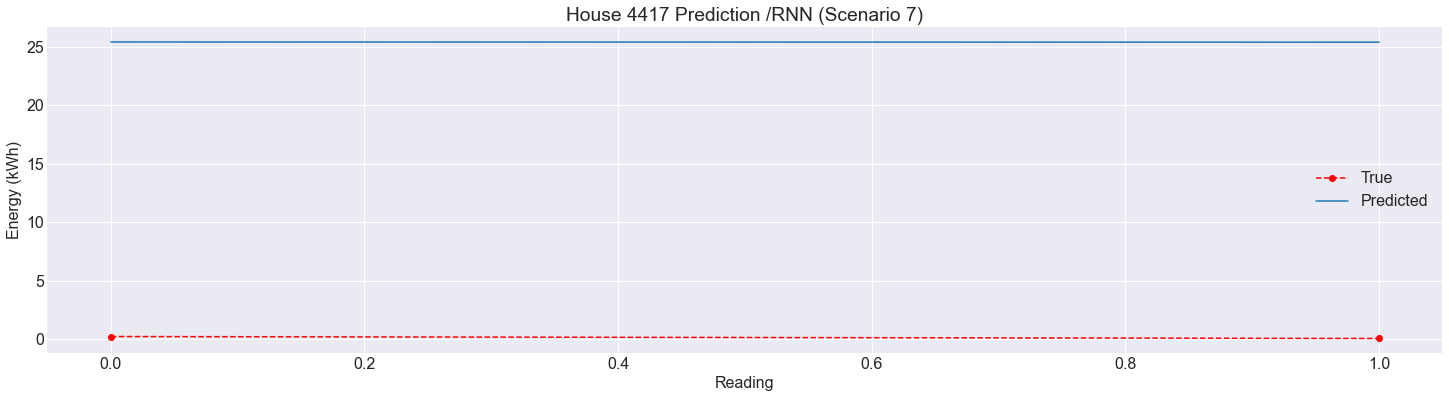

Mse:  2969.763246948951746
Rmse: 54.495534192711162
Mae:  54.495529906824231
Mape:  100.078967866159886


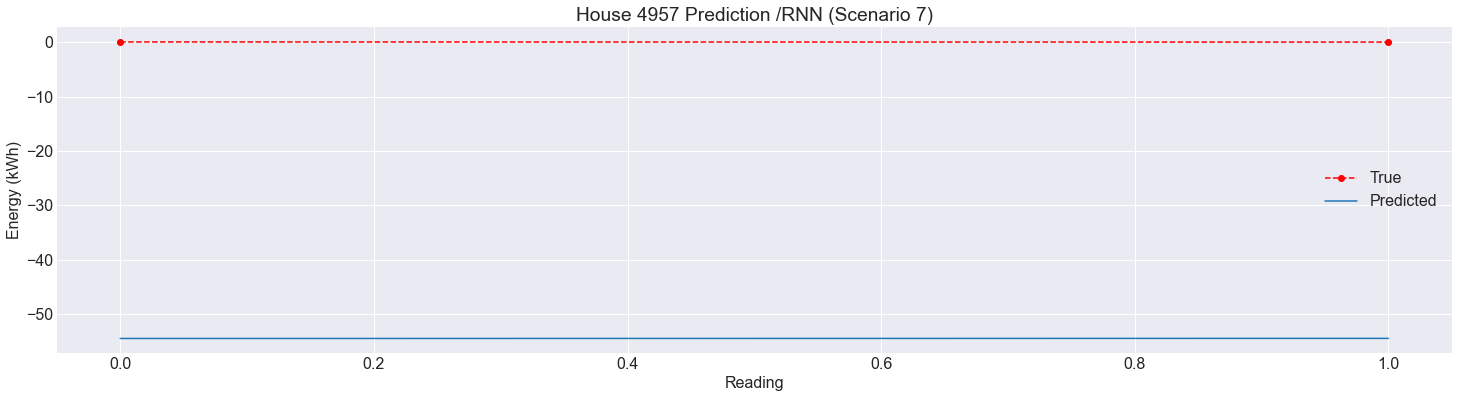

Mse:  21286.352147570658417
Rmse: 145.898430929090722
Mae:  145.898288082331419
Mape:  100.070647087945190


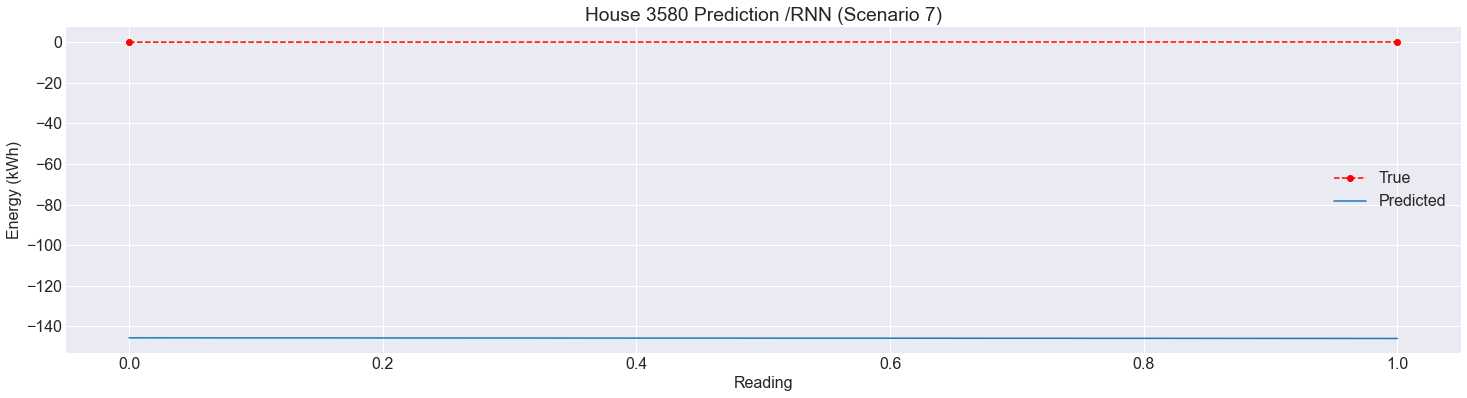

Mse:  983.209405134532972
Rmse: 31.356170128613172
Mae:  31.355924133211374
Mape:  99.655156994299830


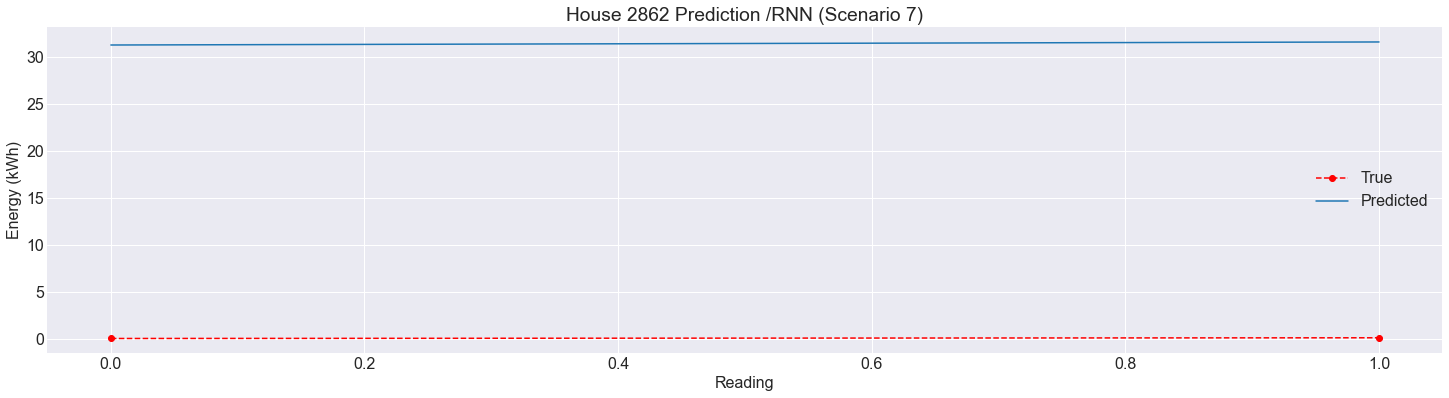

Mse:  49110.715461597115791
Rmse: 221.609375843164884
Mae:  221.609371215105057
Mape:  100.031371328085555


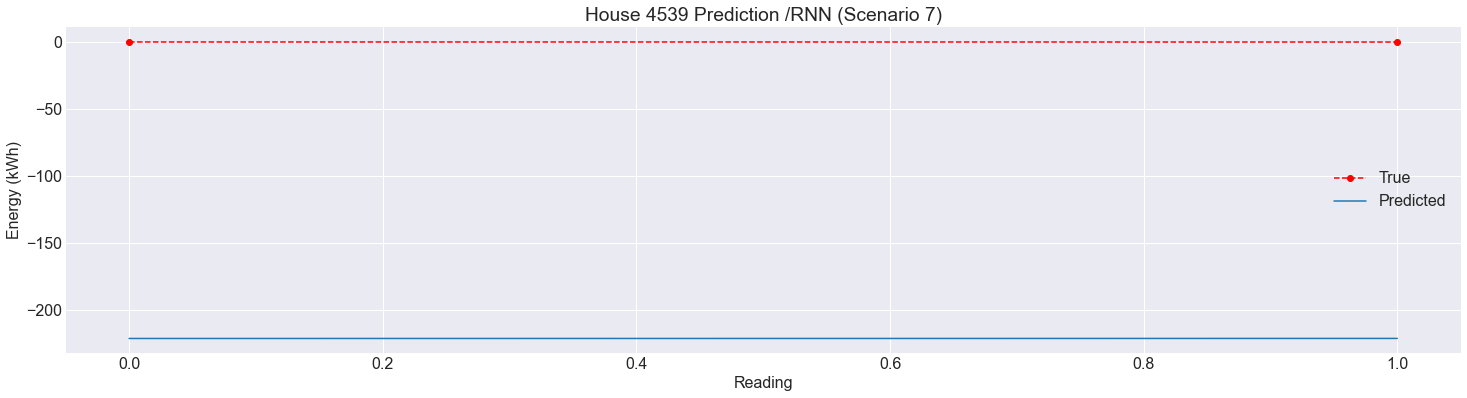

Mse:  6591.408063678084545
Rmse: 81.187487112720049
Mae:  81.187485202215612
Mape:  99.745068690508788


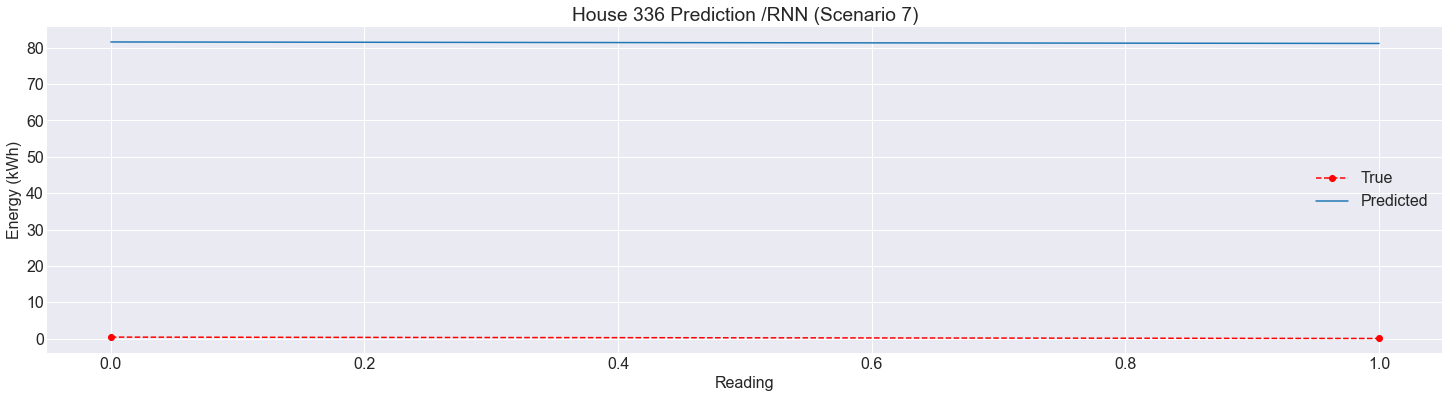

Mse:  130328.293609804910375
Rmse: 361.010101811299592
Mae:  361.008769899606705
Mape:  99.924988198715141


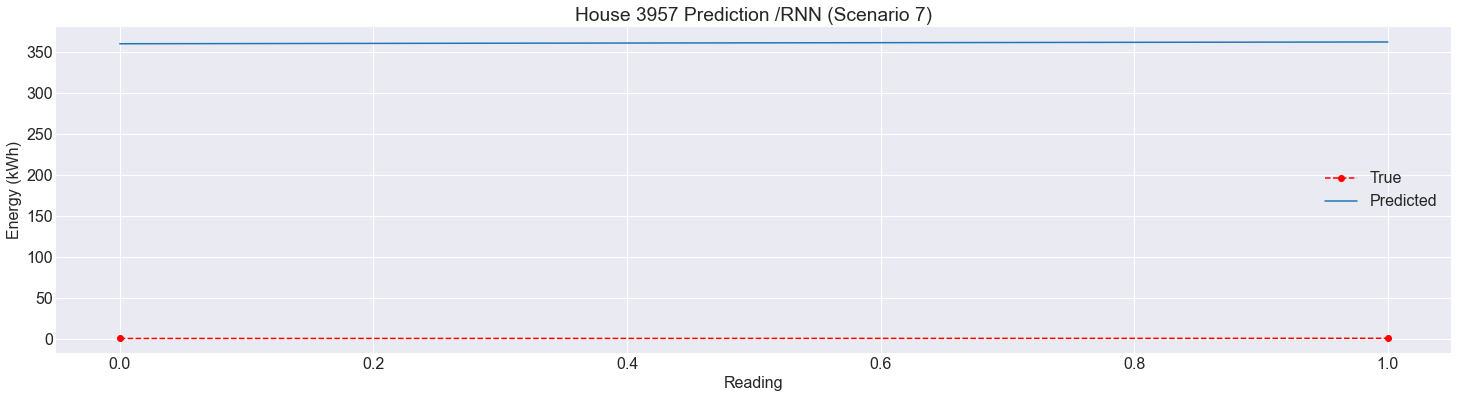

Mse:  32231.840156960177410
Rmse: 179.532281656977148
Mae:  179.526068784296513
Mape:  100.064939462017094


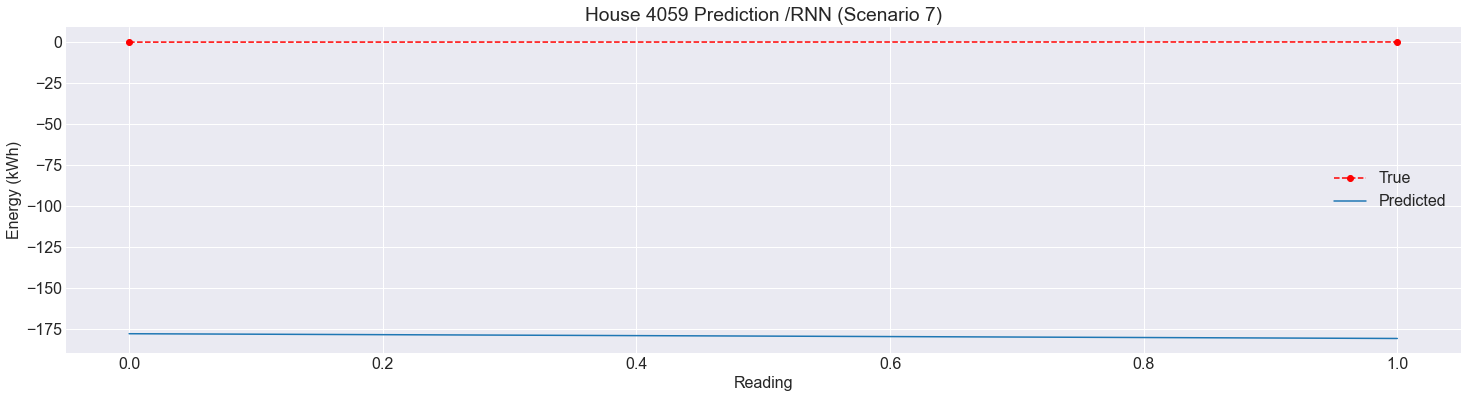

Mse:  60087.439228426024783
Rmse: 245.127393875972217
Mae:  245.127392577938735
Mape:  99.994900870603942


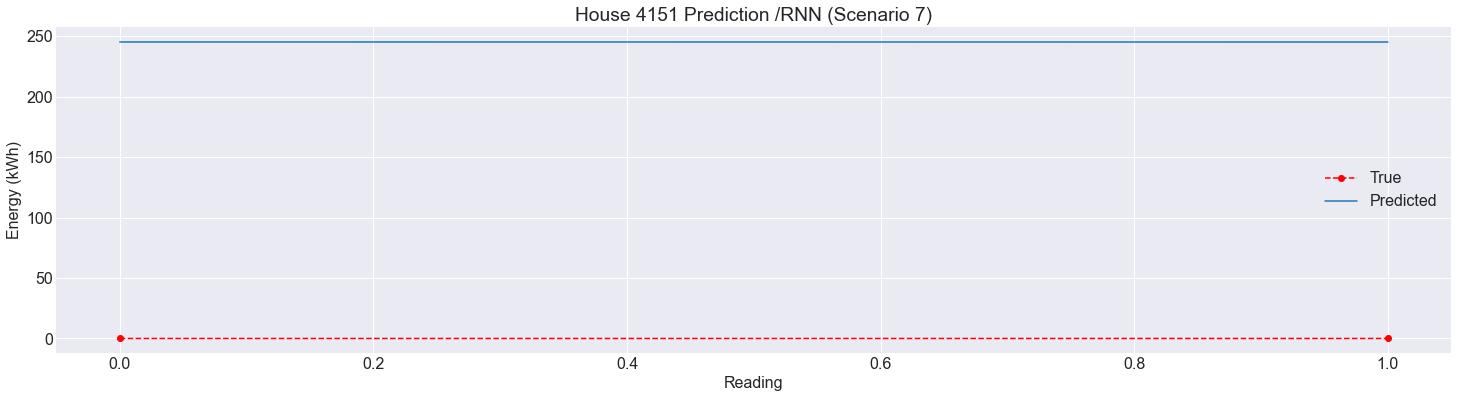

Mse:  58556.212268374431005
Rmse: 241.983909110449815
Mae:  241.983788087964058
Mape:  100.077958598361505


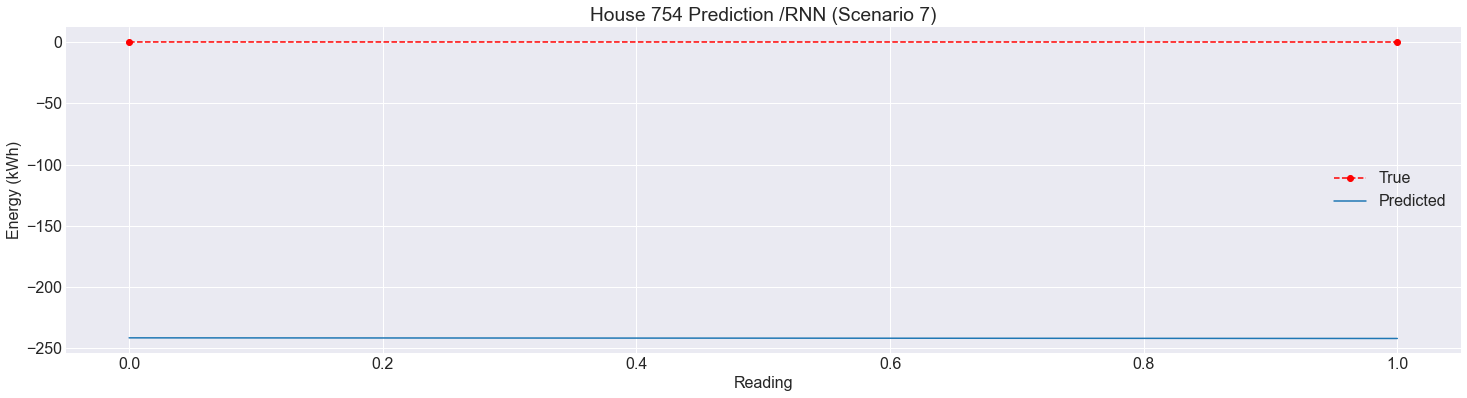

Mse:  52320.674130468956719
Rmse: 228.737128884816059
Mae:  228.737077143043280
Mape:  100.080068575879949


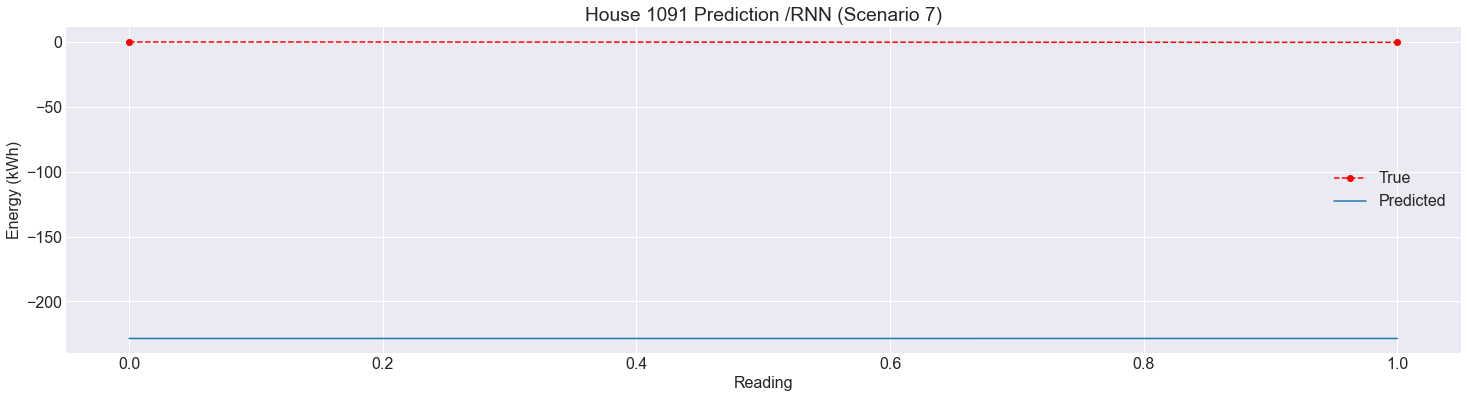

Mse:  335348.211182774160989
Rmse: 579.092575658481564
Mae:  579.092574217356741
Mape:  100.009325803324884


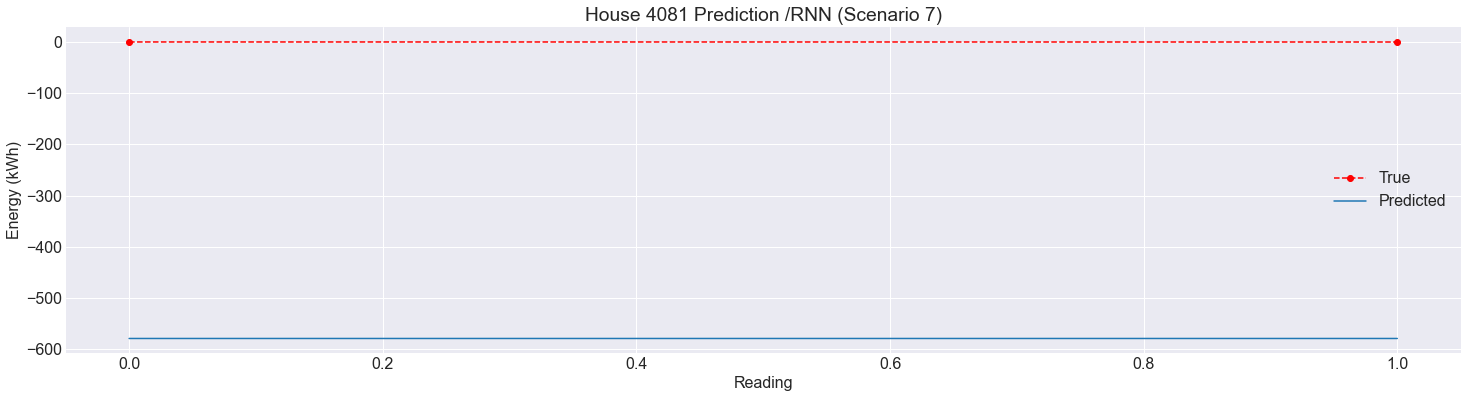

Mse:  229.148729628947422
Rmse: 15.137659318036835
Mae:  15.062798034399748
Mape:  100.333001353081741


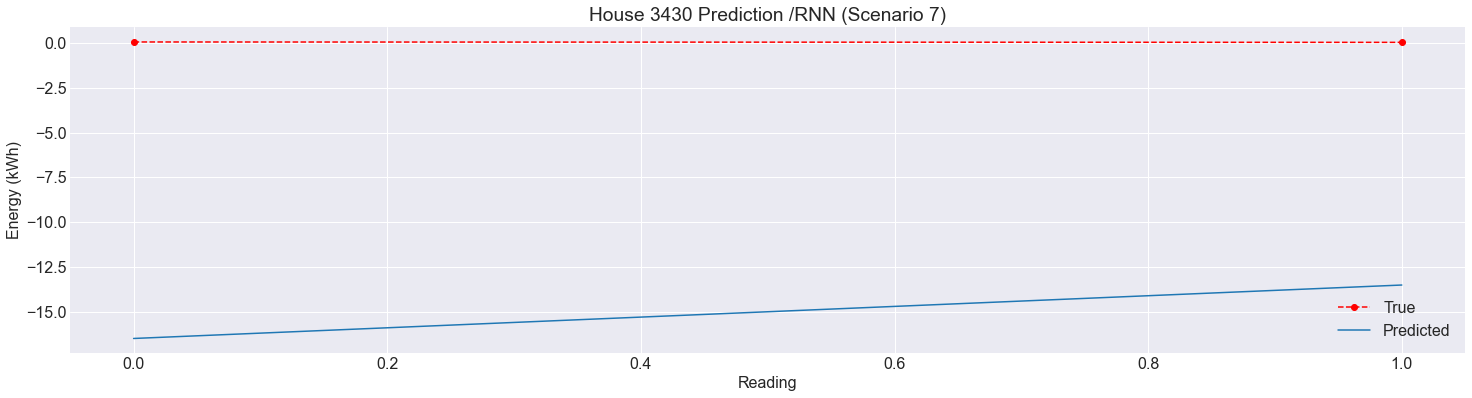

Mse:  5529.101818783887211
Rmse: 74.357930436395876
Mae:  74.357836179435253
Mape:  100.127250067827660


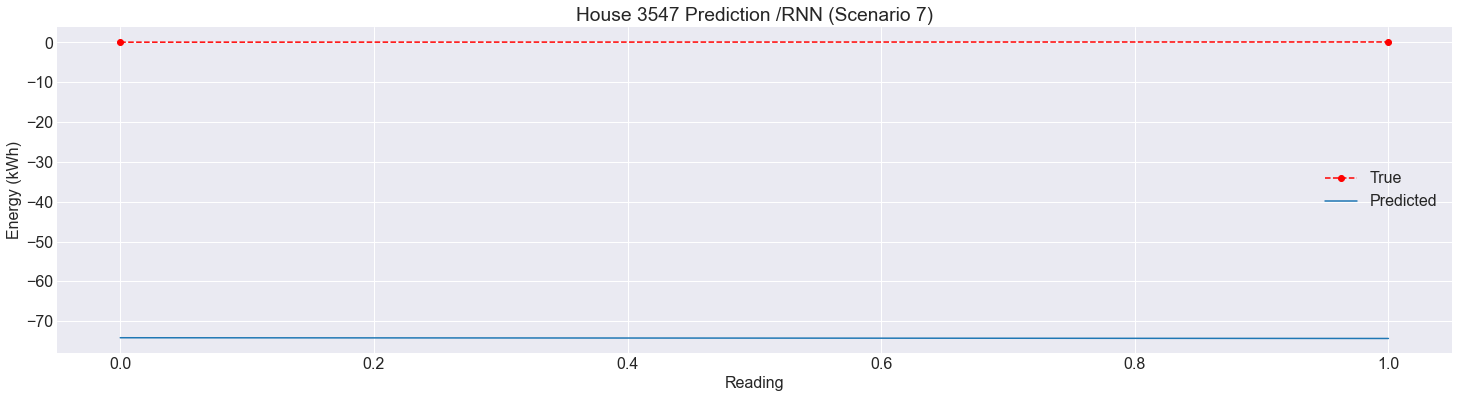

Mse:  39728.449892599121085
Rmse: 199.319968624819722
Mae:  199.319595944136381
Mape:  100.101699122503504


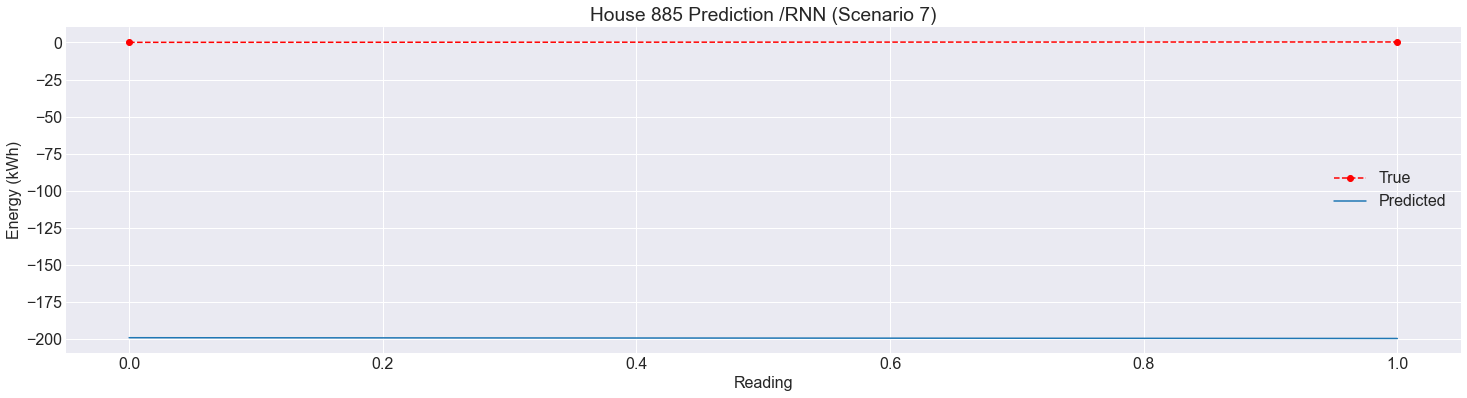

Mse:  55987.719891584827565
Rmse: 236.617243436704825
Mae:  236.617017883807421
Mape:  99.960500188292457


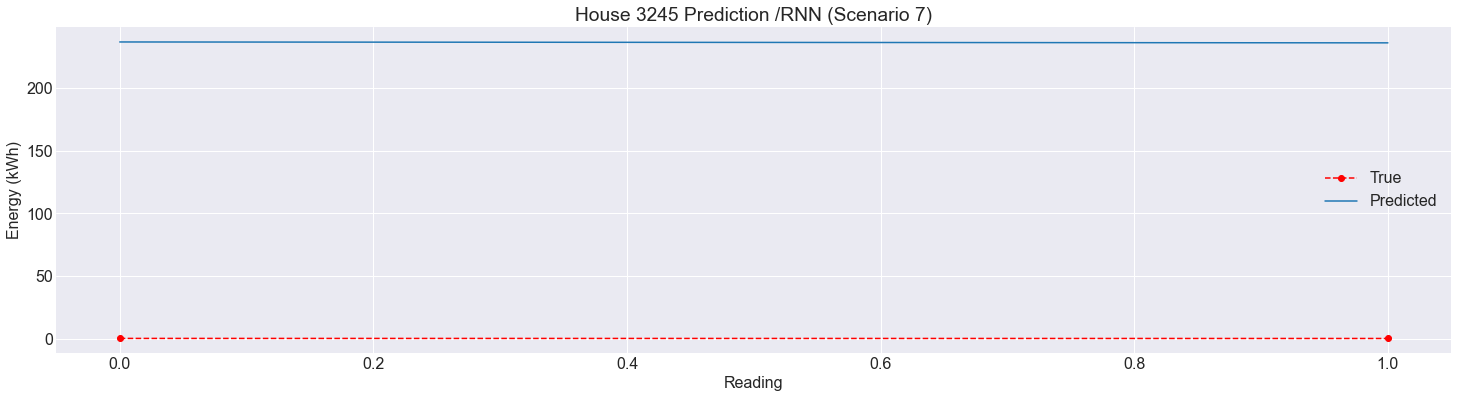

Mse:  16739.597076774567540
Rmse: 129.381594814620229
Mae:  129.379536323249340
Mape:  99.824078897870180


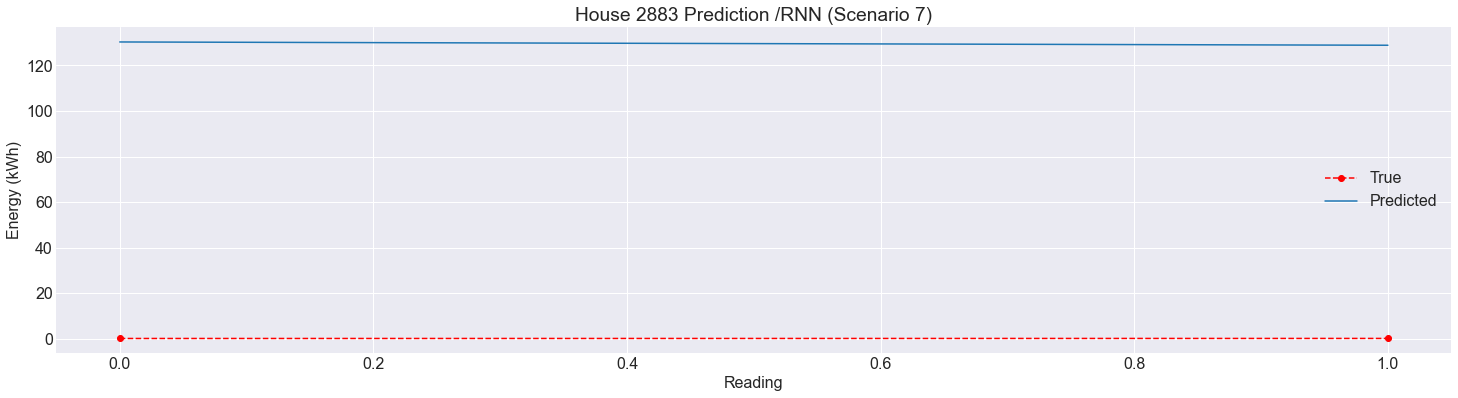

Mse:  105609.548041003959952
Rmse: 324.976226885912297
Mae:  324.976226562634110
Mape:  99.982770939220615


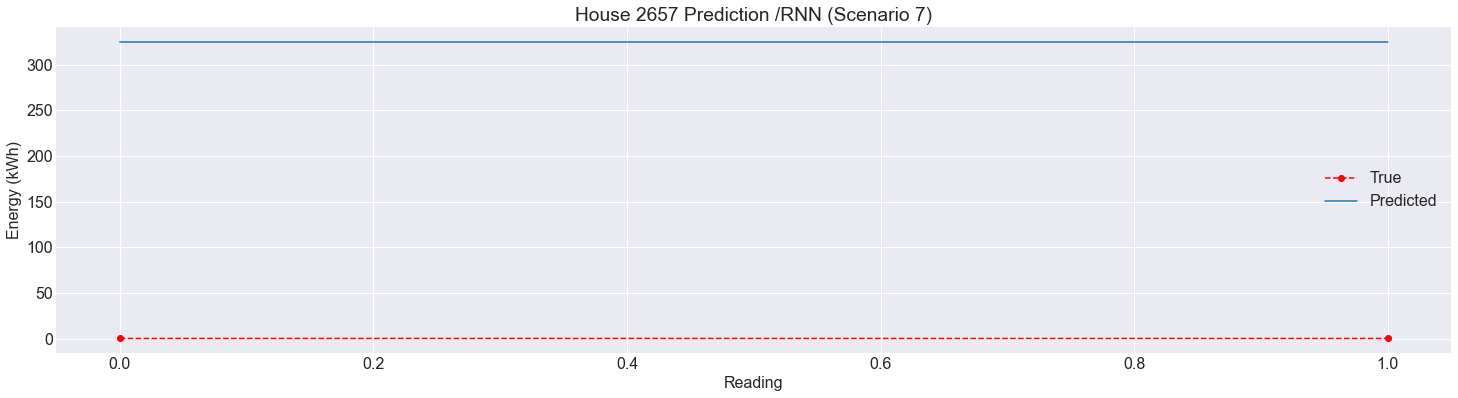

Mse:  96197.074213015381247
Rmse: 310.156531791634848
Mae:  310.156519409269094
Mape:  99.954398665557704


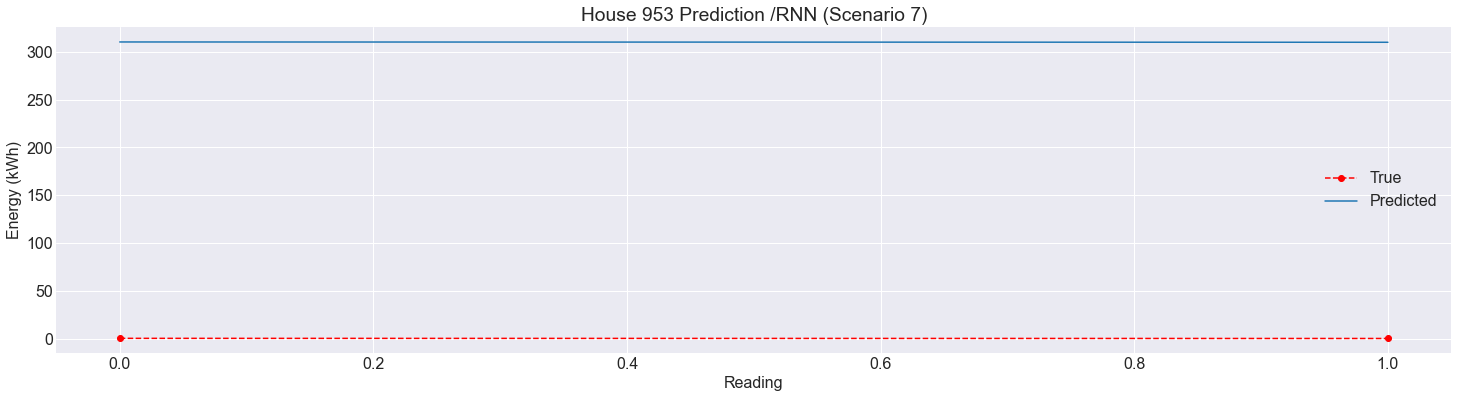

Mse:  176747.709111239295453
Rmse: 420.413735635789237
Mae:  420.413356442004442
Mape:  100.026290617252215


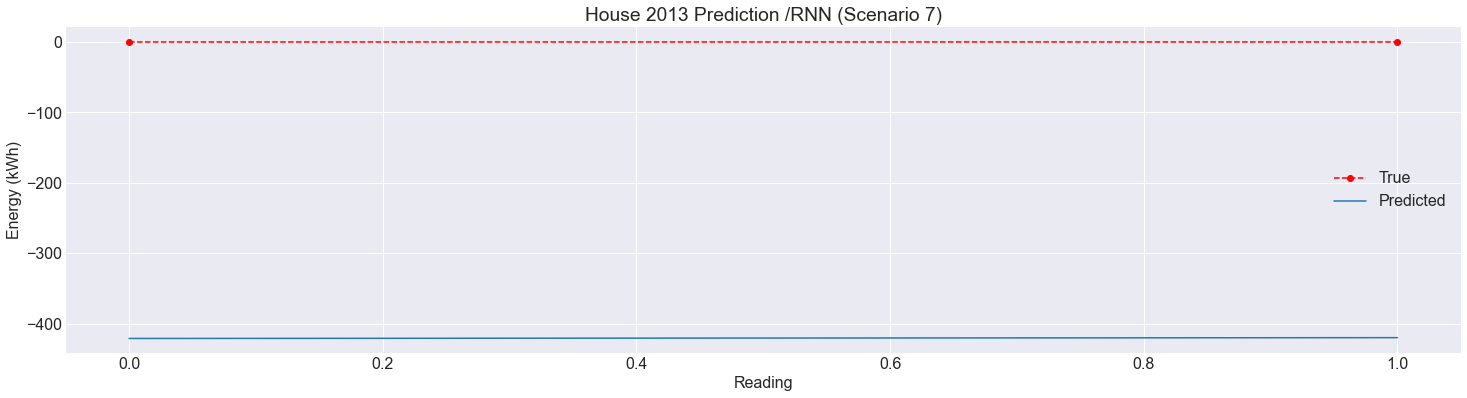

Mse:  54174.230129167677660
Rmse: 232.753582419621807
Mae:  232.753581664524972
Mape:  99.993770623308791


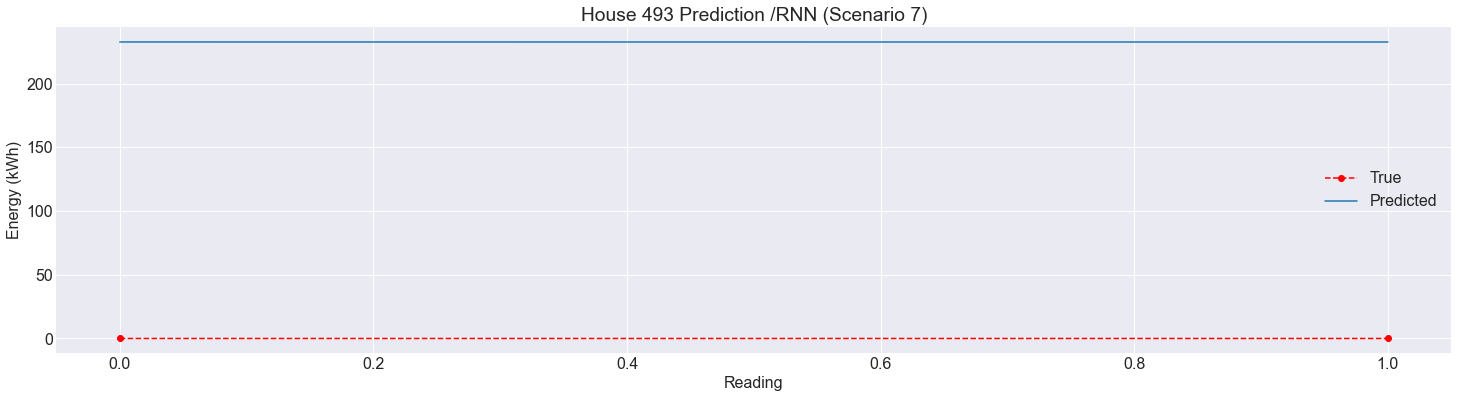

Mse:  210948.753188351925928
Rmse: 459.291577528210212
Mae:  459.291571773588657
Mape:  100.069285036837741


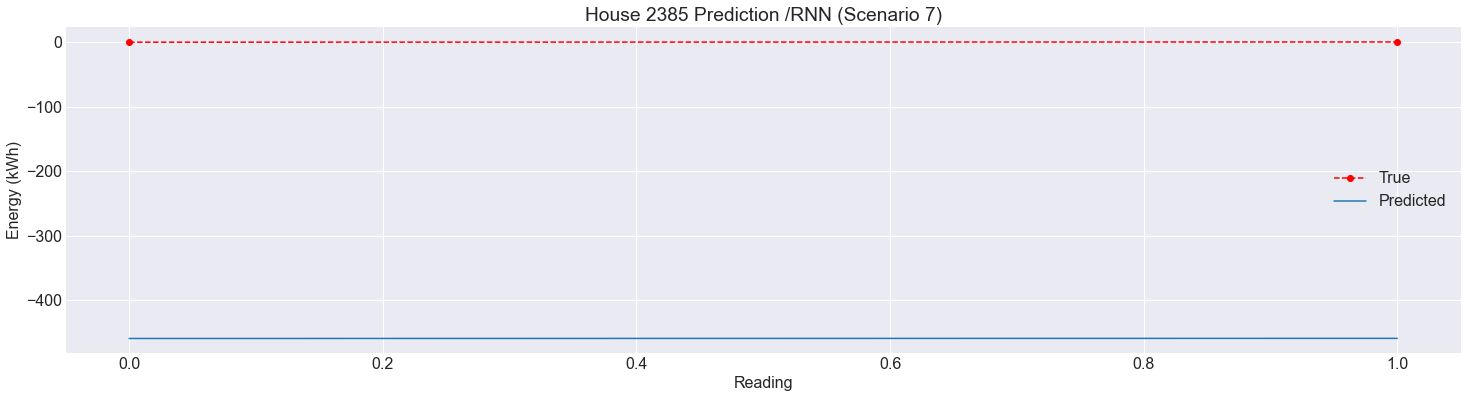

Mse:  21232.393324160118937
Rmse: 145.713394456927404
Mae:  145.712736021727324
Mape:  99.897504731343474


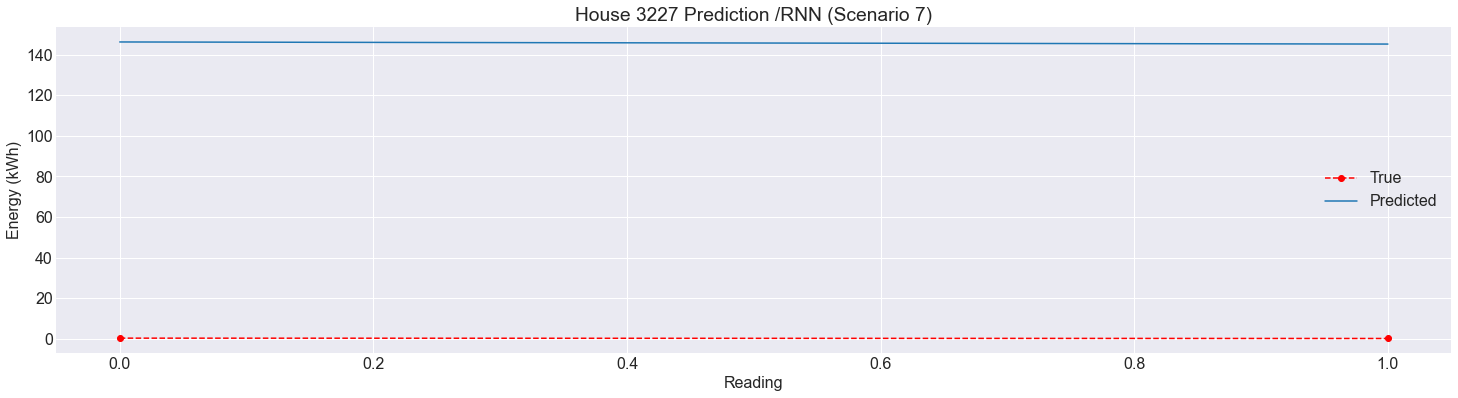

Mse:  248.301544902370523
Rmse: 15.757586899724542
Mae:  15.755214592441916
Mape:  101.885068194506218


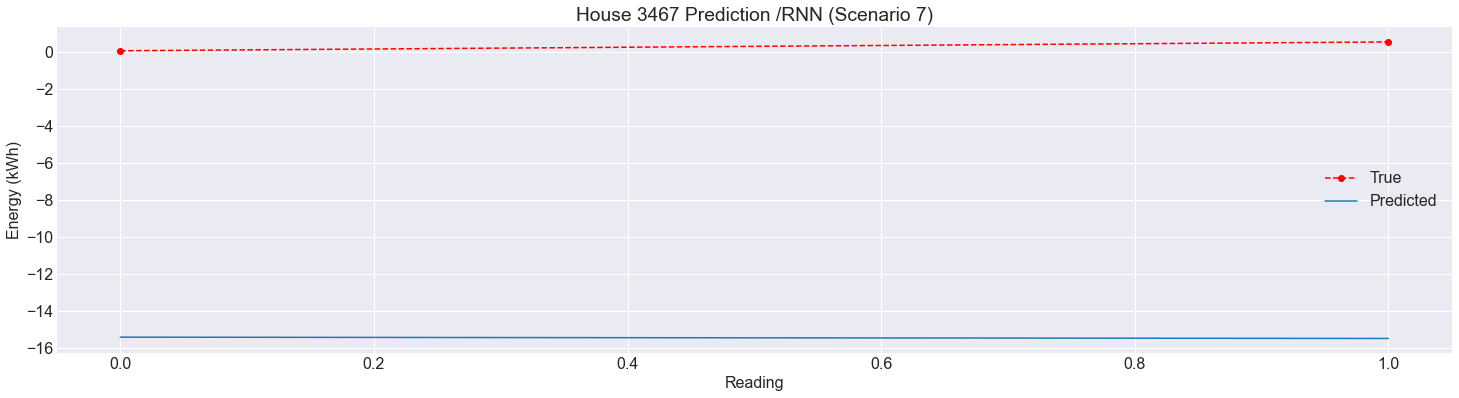

Mse:  76231.589038993144641
Rmse: 276.100686415287896
Mae:  276.097065806388855
Mape:  99.819768571773807


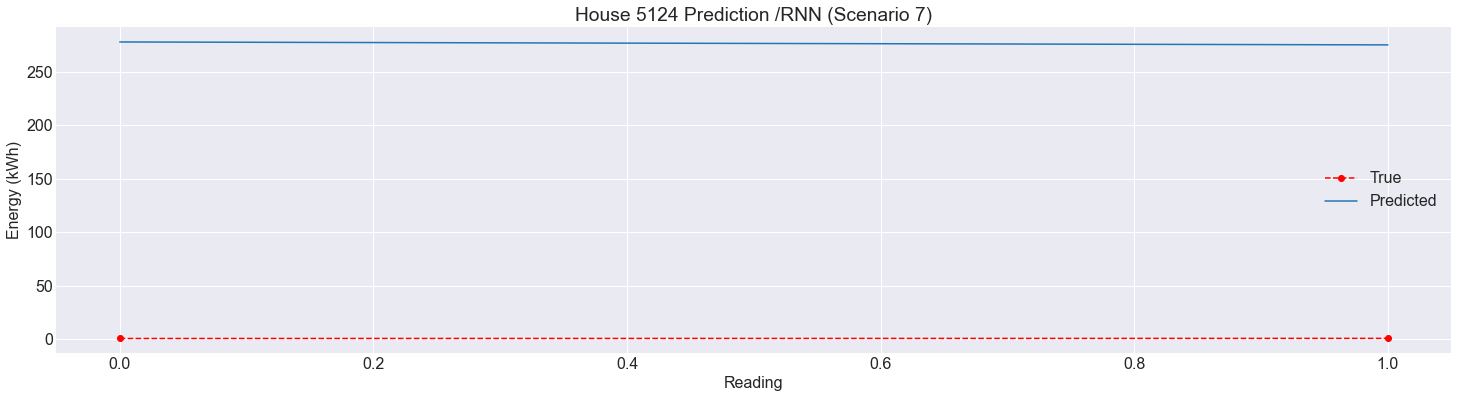

Mse:  10576.574716248411278
Rmse: 102.842475253410797
Mae:  102.842446416616440
Mape:  99.685461264564381


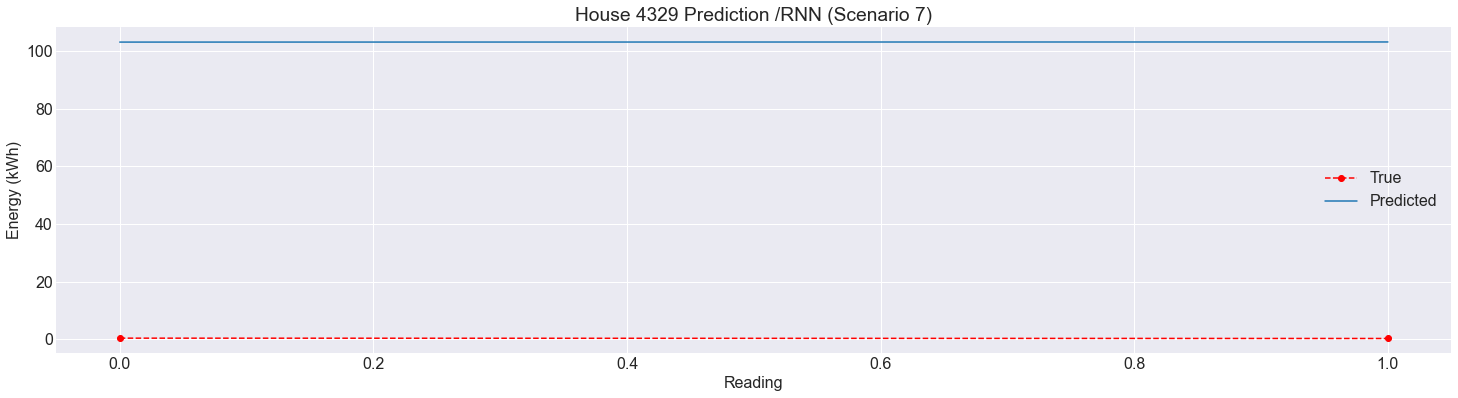

In [197]:
 ##### The households with an error have a '#' 

predict_household_AfterTuning(5492)
predict_household_AfterTuning(2)
predict_household_AfterTuning(3613)
predict_household_AfterTuning(4417)
predict_household_AfterTuning(4957)
predict_household_AfterTuning(3580)
predict_household_AfterTuning(2862)
predict_household_AfterTuning(4539)
predict_household_AfterTuning(336)
predict_household_AfterTuning(3957)
predict_household_AfterTuning(4059)
predict_household_AfterTuning(4151)
predict_household_AfterTuning(754)
predict_household_AfterTuning(1091)
predict_household_AfterTuning(4081)
predict_household_AfterTuning(3430)
predict_household_AfterTuning(3547)
predict_household_AfterTuning(885)
predict_household_AfterTuning(3245)
predict_household_AfterTuning(2883)
predict_household_AfterTuning(2657)
predict_household_AfterTuning(953)
predict_household_AfterTuning(2013)
predict_household_AfterTuning(493)
predict_household_AfterTuning(2385)
predict_household_AfterTuning(3227)
predict_household_AfterTuning(3467)
predict_household_AfterTuning(5124)
predict_household_AfterTuning(4329)




In [ ]:
models_performances_HH_level = pd.DataFrame([MSE_scores_HH, RMSE_scores_HH, MAE_scores_HH, MAPE_scores_HH],
                                   columns=households_predictions, 
                                   index=['MSE_scores', 'RMSE_scores',
                                          'MAE_scores', 'MAPE_scores'])
models_performances_HH_level

,HH_1,HH_2,HH_3,HH_4,HH_5,HH_6,HH_7,HH_8,HH_9,HH_10,...,HH_20,HH_21,HH_22,HH_23,HH_24,HH_25,HH_26,HH_27,HH_28,HH_29
MSE_scores,12035.368633,137548.761489,81508.163359,27538.460950,76651.704902,97665.731389,2726.846421,684.163856,18230.504733,68186.584906,...,32910.411680,95165.528074,71.910627,13021.139220,34175.006672,31400.541380,27.105133,113898.479431,84420.835298,108520.660481
RMSE_scores,109.705828,370.875669,285.496346,165.947163,276.860443,312.515170,52.219215,26.156526,135.020386,261.125611,...,181.412270,308.489105,8.480013,114.110206,184.864834,177.201979,5.206259,337.488488,290.552638,329.424742
MAE_scores,109.705822,370.875609,285.496344,165.947156,276.860442,312.515140,52.219167,26.156523,135.019894,261.125340,...,181.411144,308.489105,8.480001,114.109634,184.864833,177.201814,5.109831,337.488415,290.552525,329.424737
MAPE_scores,100.113614,99.958224,99.885069,100.093792,99.984471,100.032969,99.792652,99.734996,99.846554,100.103890,...,100.125841,99.981850,101.697132,100.096931,99.992157,99.820865,97.068333,100.086448,99.828724,99.901592


In [ ]:
models_performances_HH_level.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/model_performance/models_performances_HH_level_Scenario3_1h.csv', index=False)

In [ ]:
## Best regression model

In [198]:
MSE_scores_HH = []
RMSE_scores_HH = []
MAE_scores_HH = []
MAPE_scores_HH = []
households_predictions = ['HH_1',
                      'HH_2',
                      'HH_3',
                      'HH_4',
                      'HH_5',
                      'HH_6',
                      'HH_7',
                      'HH_8',
                      'HH_9',
                      'HH_10',
                      'HH_11',
                      'HH_12',
                      'HH_13',
                      'HH_14',
                      'HH_15',
                      'HH_16',
                      'HH_17',
                      'HH_18',
                      'HH_19',
                      'HH_20',
                      'HH_21',
                      'HH_22',
                      'HH_23',
                      'HH_24',
                      'HH_25',
                      'HH_26',
                      'HH_27',
                      'HH_28', 
                      'HH_29']

In [199]:
# tune the Rf parametersbegining with house numbber of your choice 
def predict_household_AfterTuning(num):
  house = updated_houses[updated_houses.LCLid==num]

  np.random.seed(5)
  dataframe = house.loc[:,'energy(kWh/hh)']
  dataset = dataframe.values
  dataset = dataset.astype('float32')

  reframed = series_to_supervised(dataset, 24,1)

  # Select required columns and merge with supervised data
  df=house[weather_energy.columns[1:]]
  df = df[12:]
  reframed = pd.concat([df, reframed], axis=1).dropna()

  reframed = reframed.reindex(reframed.columns, axis=1)
  reframed = reframed.values

  # split into train and test sets''''
  train = reframed[:(len(reframed)-2), :]
  test = reframed[(len(reframed)-2):len(reframed), :]

  #test_X, labels = test[:, :-1], test[:, -1]
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]


  model = LinearSVR(C=8, 
                  dual=False, 
                  epsilon=0.001, loss='squared_epsilon_insensitive') 
  model.fit(train_X, train_y)

  predicted = model.predict(test_X)

  mse_HH = mean_squared_error(predicted,test_y.ravel())
  rmse_HH = mean_squared_error(predicted,test_y.ravel(), squared=False)
  mae_HH = mean_absolute_error(predicted,test_y.ravel())
  mape_HH = mean_absolute_percentage_error(predicted, test_y.ravel())

  print(f'Mse:  {mse_HH:.15f}')
  print(f'Rmse: {rmse_HH:.15f}')
  print(f'Mae:  {mae_HH:.15f}')
  print(f'Mape:  {mape_HH:.15f}')
  #print(f'Training time: {train_time_HH:.3f} s') 

  MSE_scores_HH.append(mse_HH)
  RMSE_scores_HH.append(rmse_HH)
  MAE_scores_HH.append(mae_HH)
  MAPE_scores_HH.append(mape_HH)
#  train_times_HH.append(train_time)

  matplotlib.rcParams.update({'font.size': 16})
  predicted_house = pd.DataFrame({'Predicted':predicted.ravel(),'True Reading':test_y.ravel()})
  predicted_house['True Reading'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
  predicted_house['Predicted'].plot()
  plt.title(f'House {num} Prediction /SVR (Scenario 7)')
  plt.xlabel('Reading')
  plt.ylabel('Energy (kWh)')
  # style

  plt.style.use('seaborn-darkgrid')
  palette = plt.get_cmap('Set1')

  plt.grid(b=True, which='major', color='w', linewidth=1.0)
  plt.legend(['True','Predicted'])
  plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario7/2_singleHouseholdLevel/best_regression_model/S7_1h_SVR_HH'+str(num) + '.jpeg', dpi = 500)
  plt.show()


Mse:  0.001526613984536
Rmse: 0.039071907869153
Mae:  0.030009573217187
Mape:  20.239318647734112


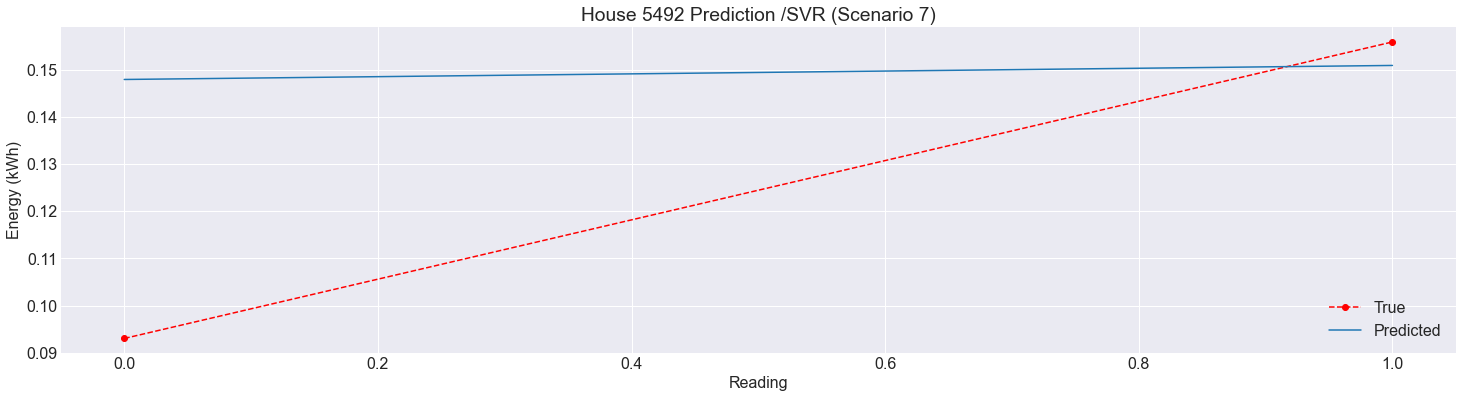

Mse:  0.006228050764077
Rmse: 0.078918000253914
Mae:  0.078294923396319
Mape:  197.664411464314384


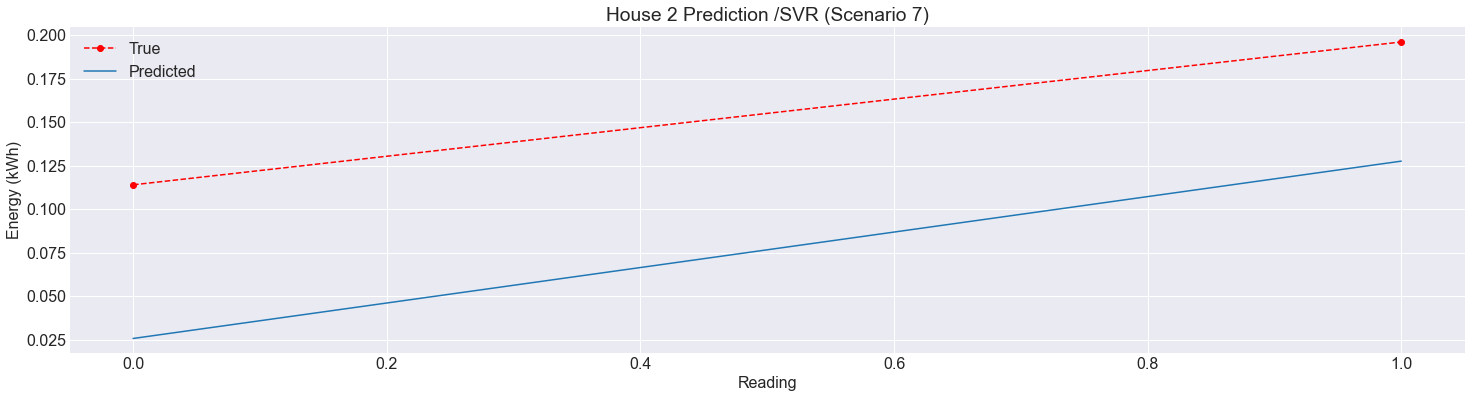

Mse:  0.079346895194572
Rmse: 0.281685809359599
Mae:  0.267369169919877
Mape:  44.038066367790840


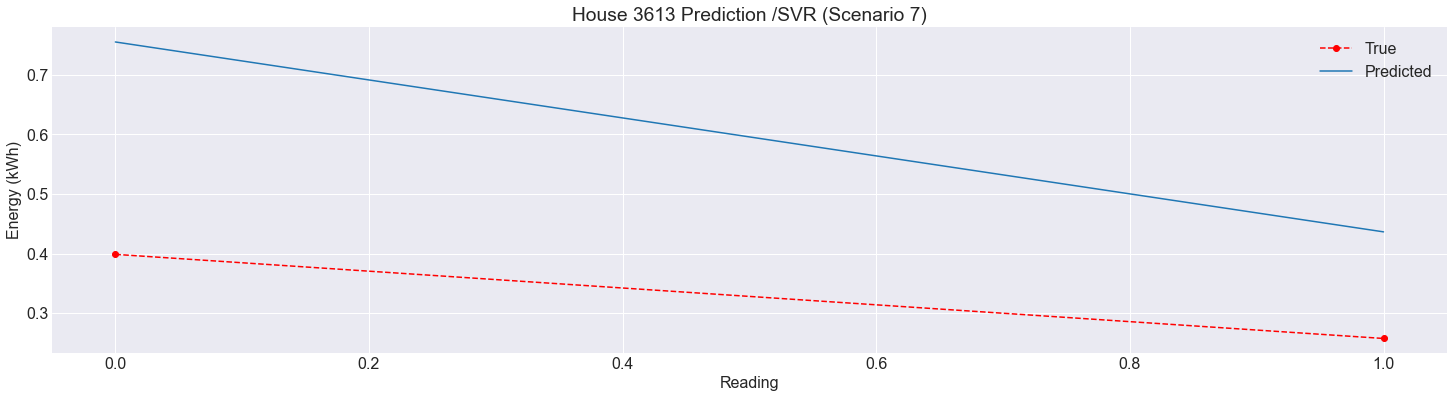

Mse:  0.008062976977991
Rmse: 0.089794080974141
Mae:  0.072849738678876
Mape:  74.848140636822876


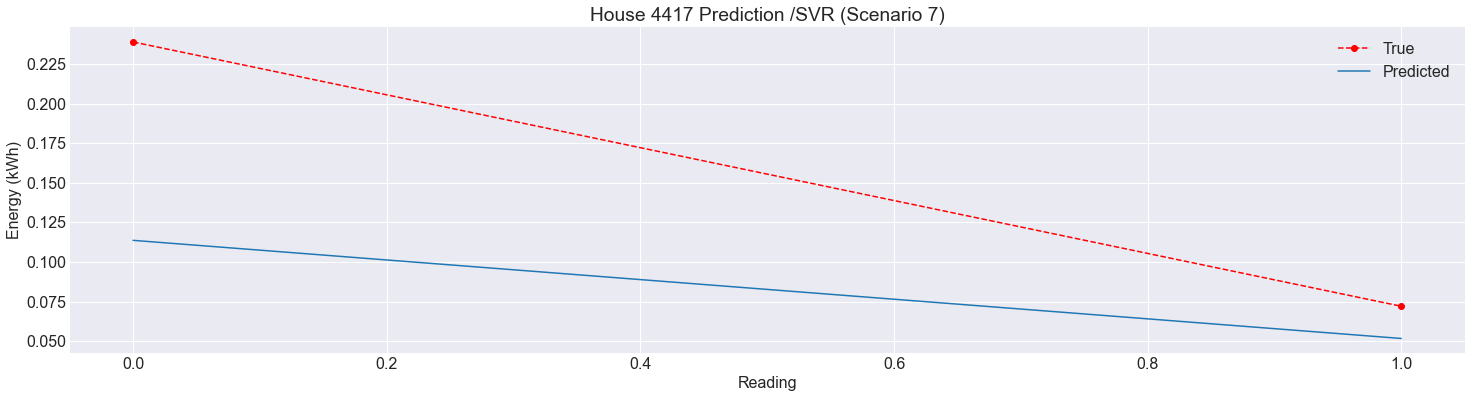

Mse:  0.000198866691359
Rmse: 0.014102010188570
Mae:  0.011964230181669
Mape:  23.718546659841444


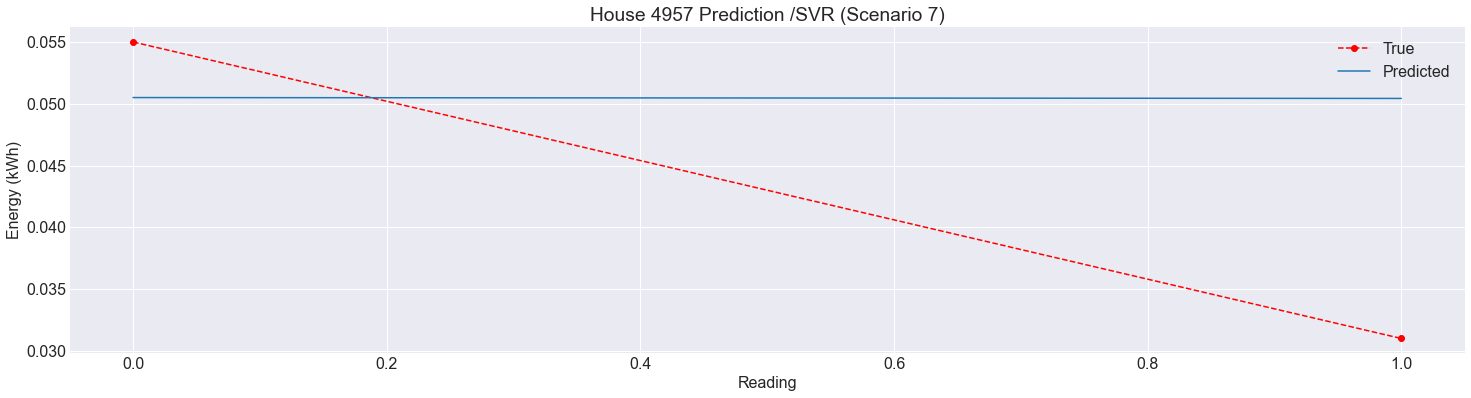

Mse:  0.001657525859629
Rmse: 0.040712723559461
Mae:  0.037834964321521
Mape:  32.418970538257021


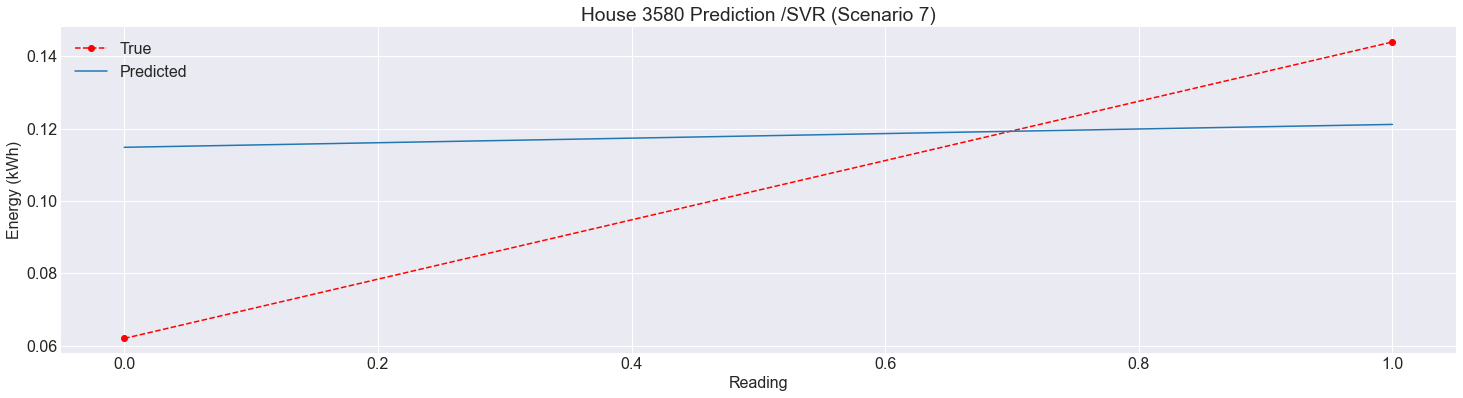

Mse:  0.093868407864341
Rmse: 0.306379516065191
Mae:  0.280905432515757
Mape:  71.246189232042894


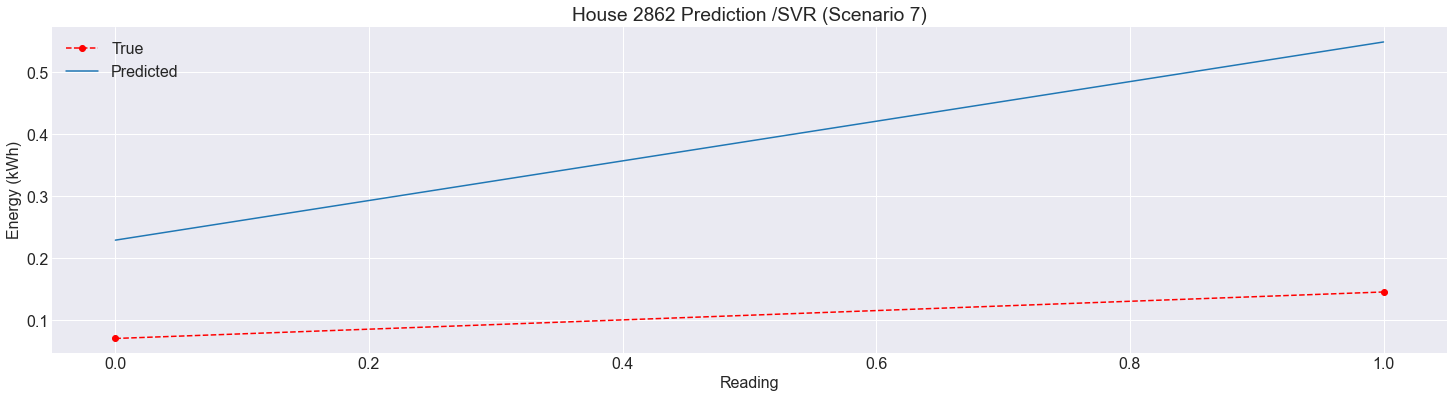

Mse:  0.002606363166615
Rmse: 0.051052552988220
Mae:  0.050843460551176
Mape:  44.047225377231527


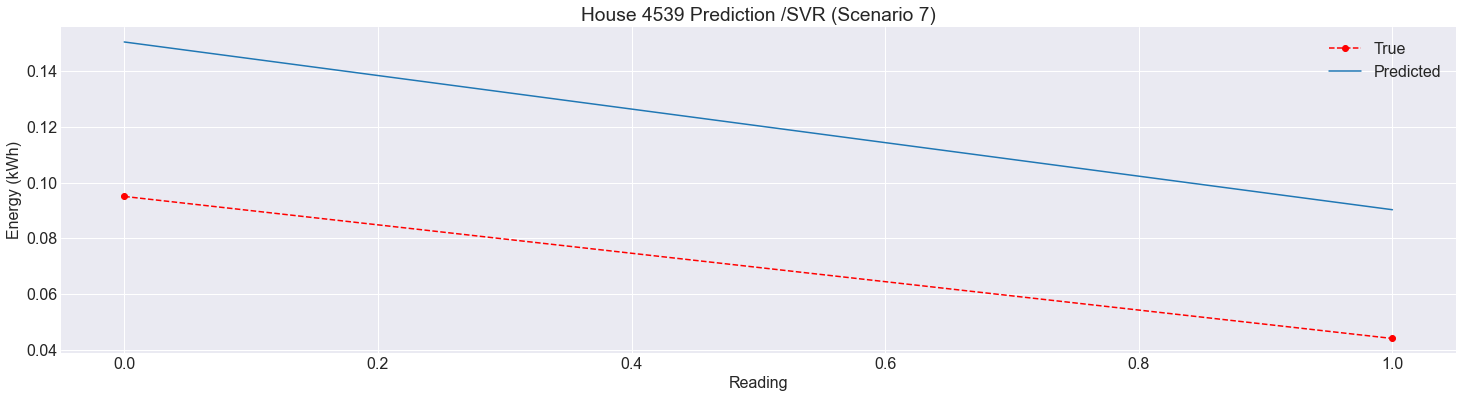

Mse:  0.002846745917898
Rmse: 0.053354905284311
Mae:  0.048566243912339
Mape:  38.808933374370305


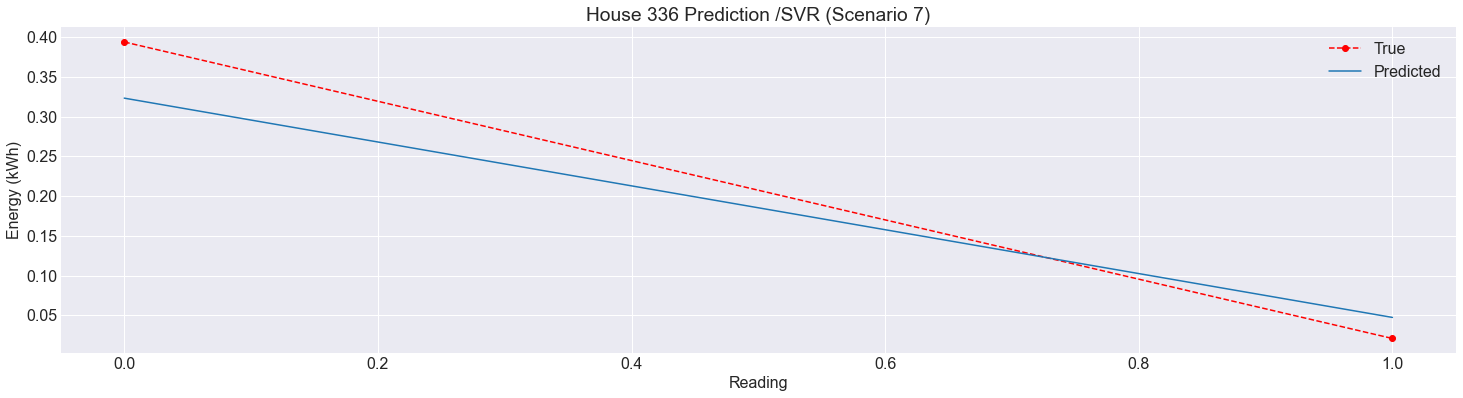

Mse:  0.013249191986316
Rmse: 0.115105134491544
Mae:  0.103857476536646
Mape:  46.419387430259981


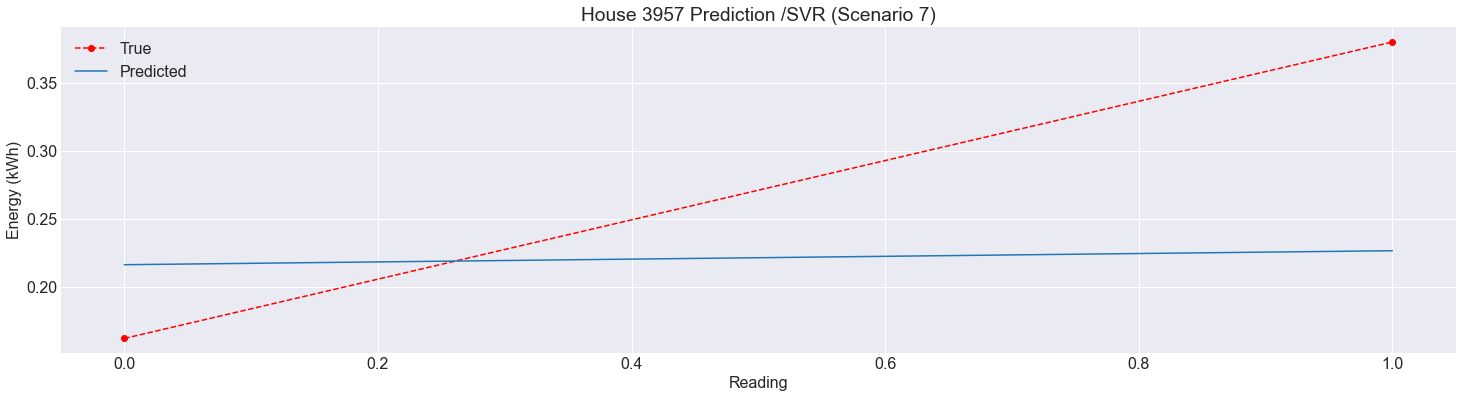

Mse:  0.004186355292118
Rmse: 0.064702050138444
Mae:  0.049949878999896
Mape:  30.672561281206502


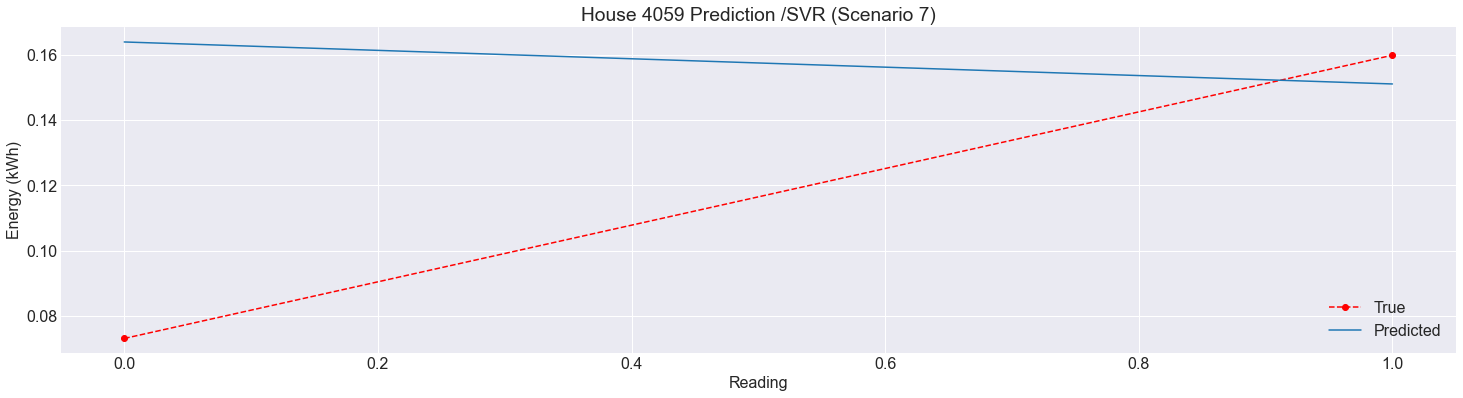

Mse:  0.004240563598094
Rmse: 0.065119609935056
Mae:  0.065116463745563
Mape:  83.893953804147728


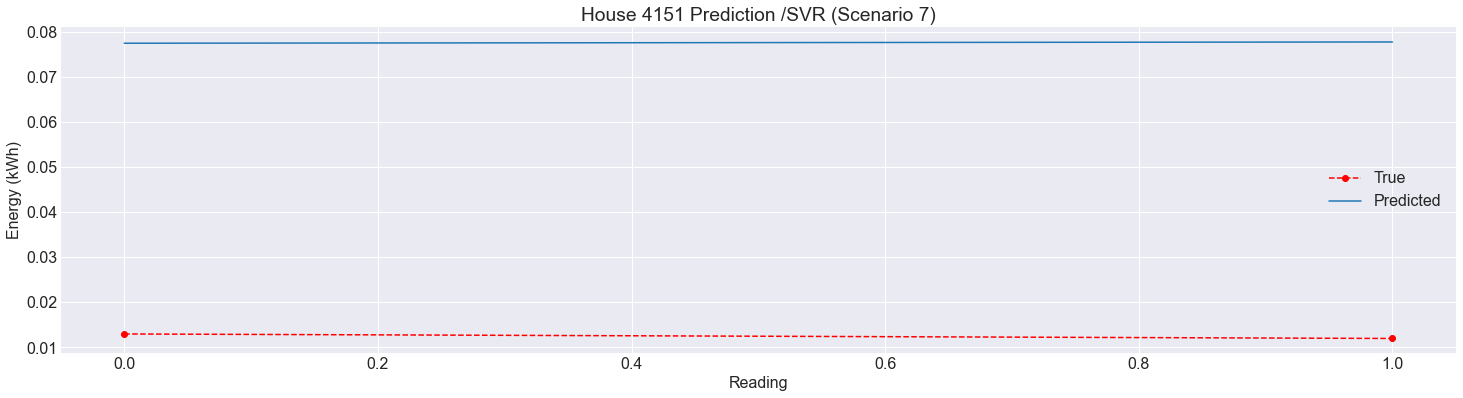

Mse:  0.003044796108524
Rmse: 0.055179671152739
Mae:  0.045220367660117
Mape:  33.642800100854096


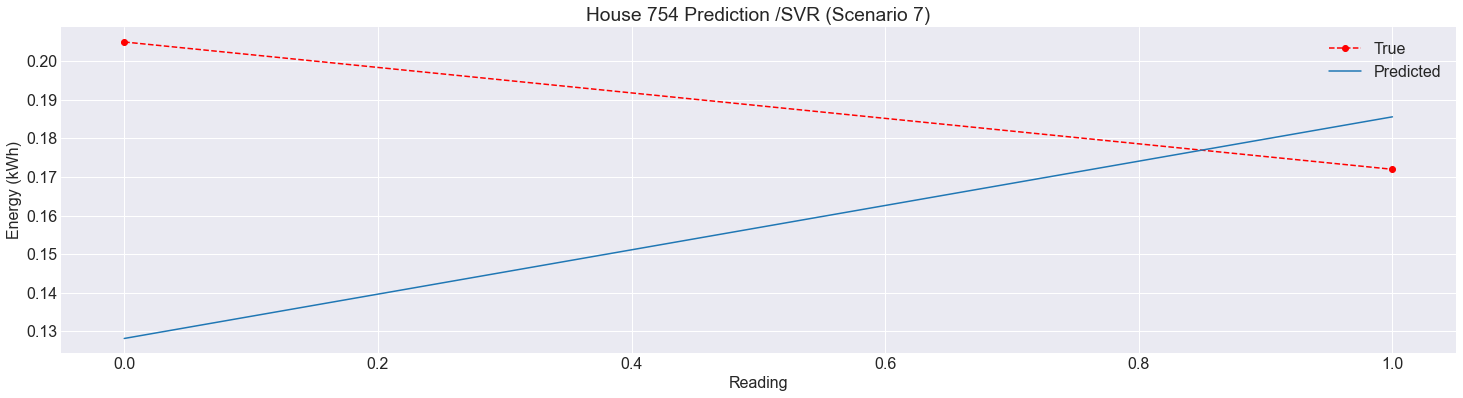

Mse:  0.025621669133989
Rmse: 0.160067701720205
Mae:  0.132169119599719
Mape:  129.141824647190731


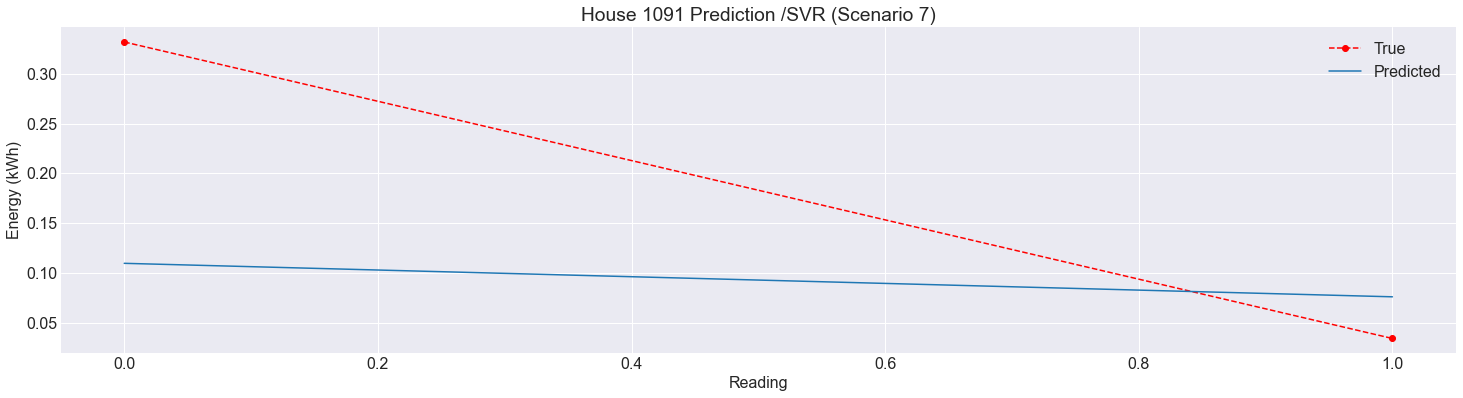

Mse:  0.005117972892415
Rmse: 0.071540009032811
Mae:  0.059420941855506
Mape:  52.439792946357969


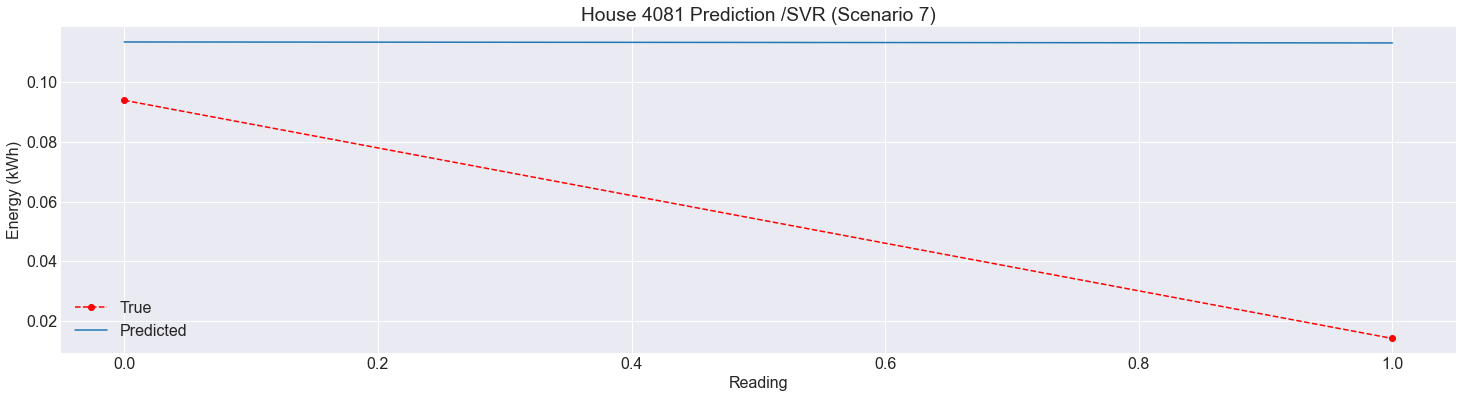

Mse:  0.004536591394983
Rmse: 0.067354223289877
Mae:  0.054278789345598
Mape:  44.021934166934138


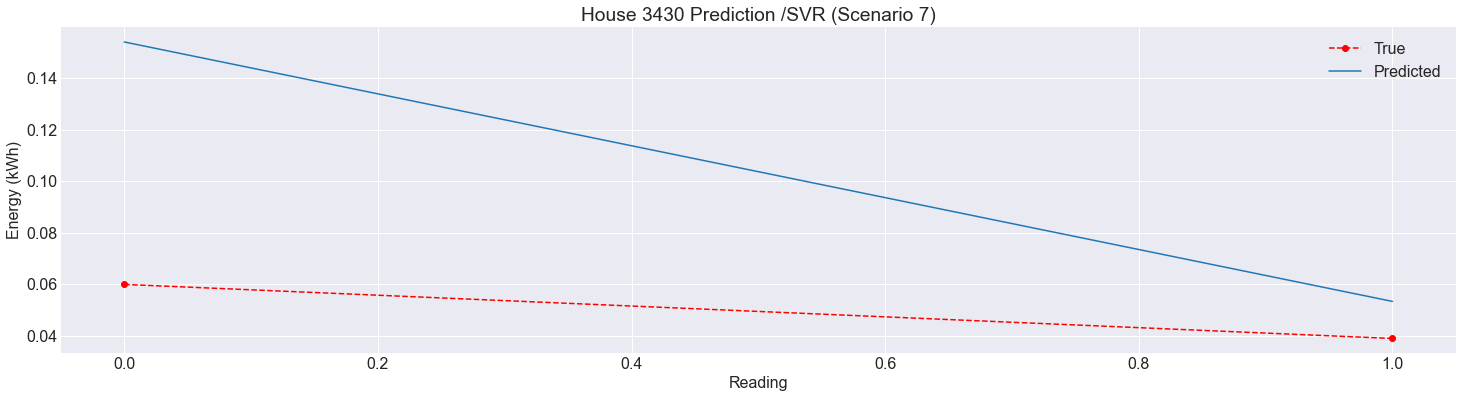

Mse:  0.026796889539762
Rmse: 0.163697555081808
Mae:  0.123374741963319
Mape:  118.902618148469145


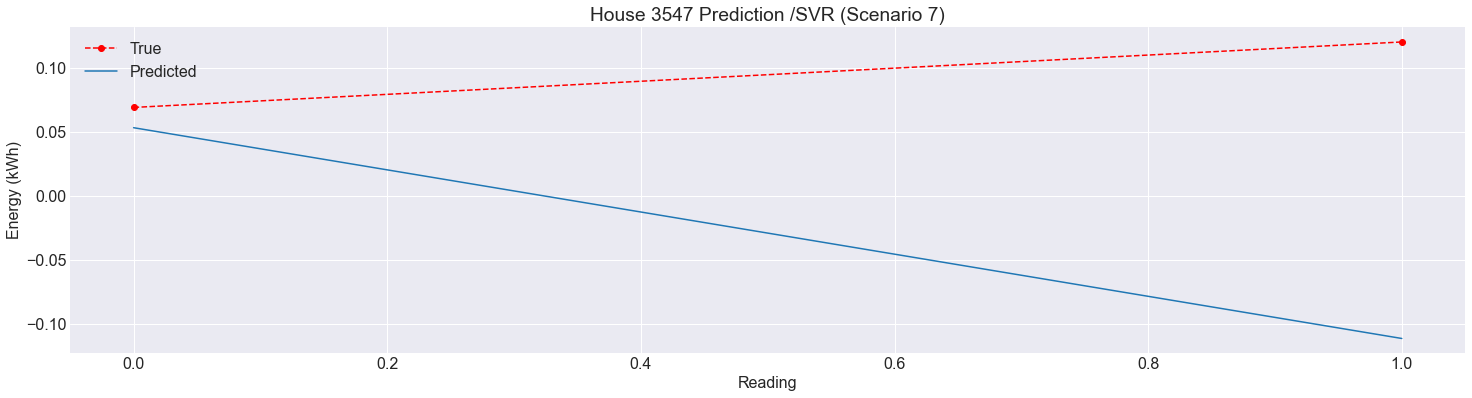

Mse:  0.210891129112452
Rmse: 0.459228841768950
Mae:  0.459171161230562
Mape:  72.121437930274041


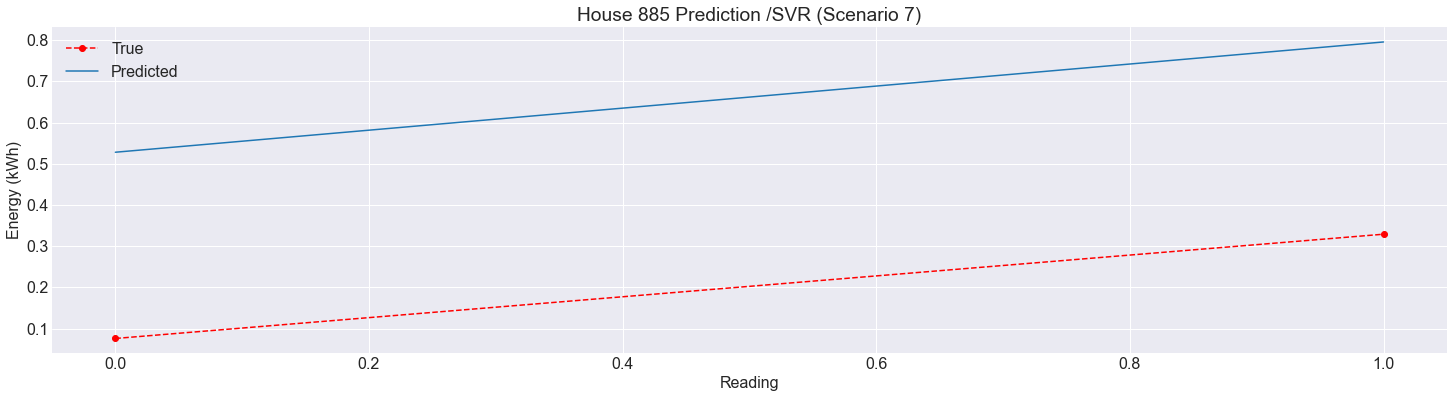

Mse:  0.009249416284185
Rmse: 0.096173885666458
Mae:  0.069088438798129
Mape:  98.034132802142423


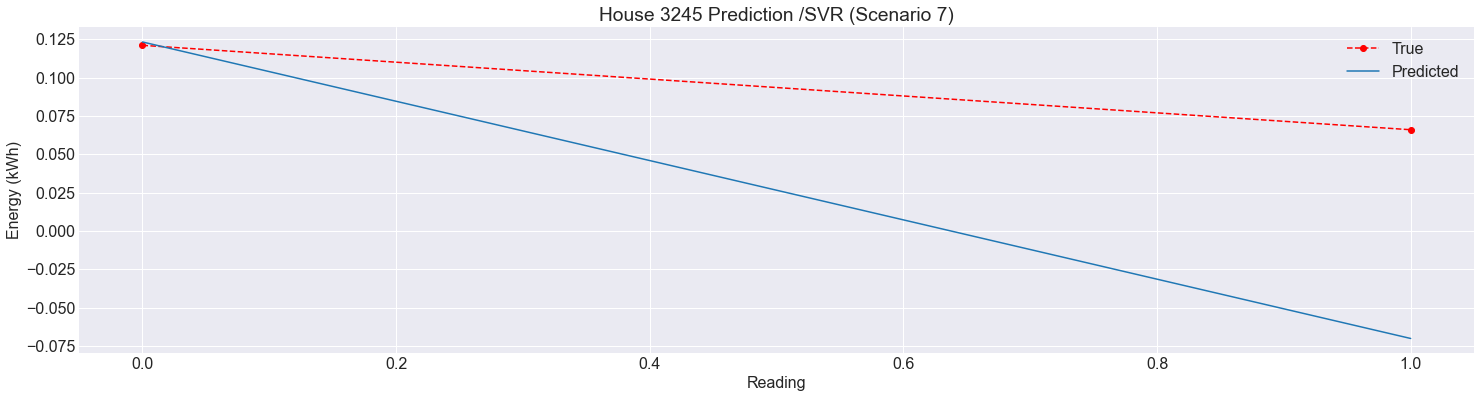

Mse:  0.005378985720189
Rmse: 0.073341568841887
Mae:  0.072721478502966
Mape:  24.198532388496453


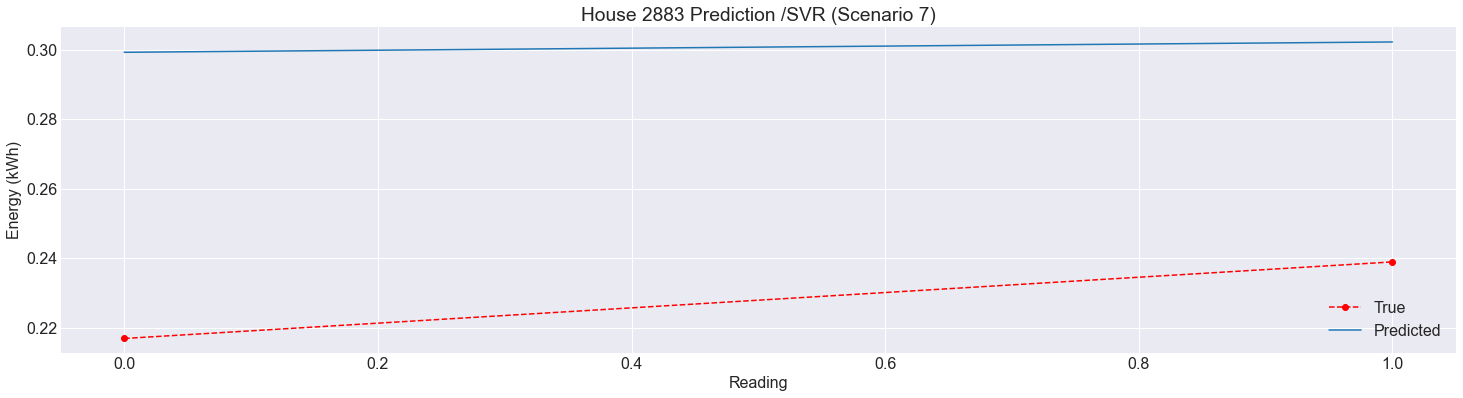

Mse:  0.010600920907185
Rmse: 0.102960773633385
Mae:  0.102165278760518
Mape:  64.605667874830928


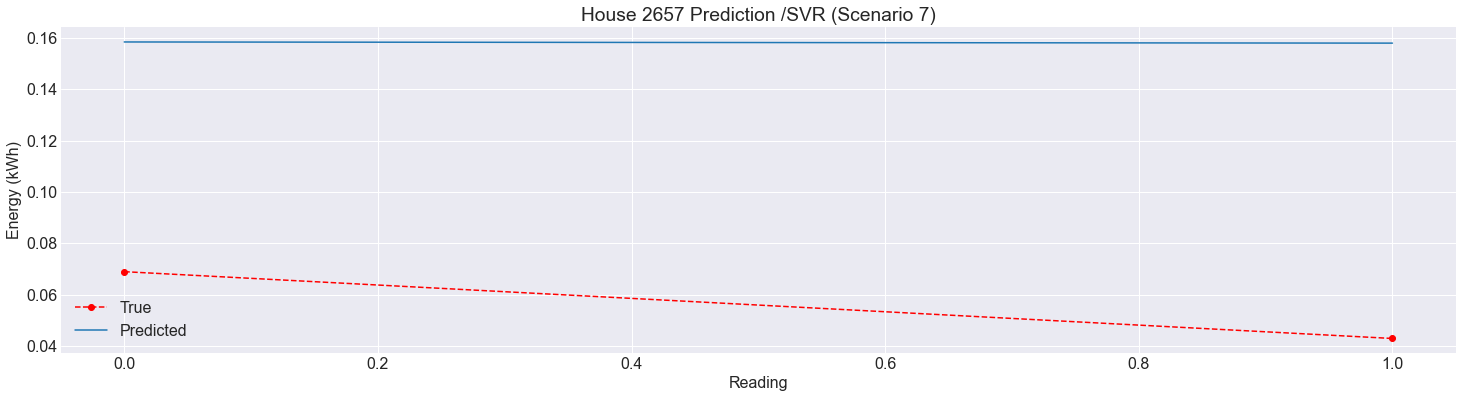

Mse:  0.005574194978842
Rmse: 0.074660531600315
Mae:  0.073097169933940
Mape:  57.933396819748474


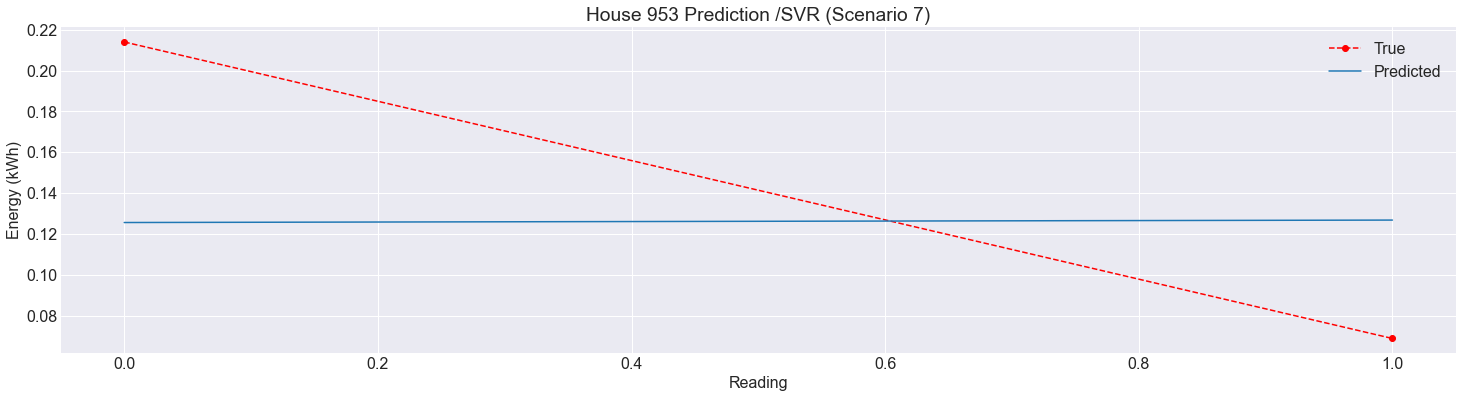

Mse:  0.003248788434240
Rmse: 0.056998144129783
Mae:  0.044831285869251
Mape:  23.581383106878619


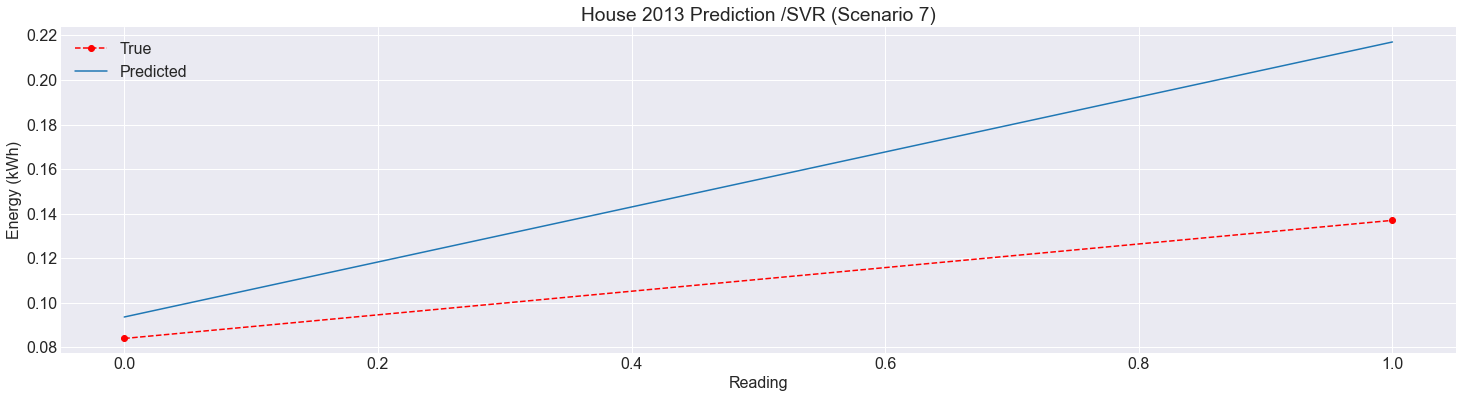

Mse:  0.016879935416958
Rmse: 0.129922805607630
Mae:  0.129771045316292
Mape:  89.976392143434765


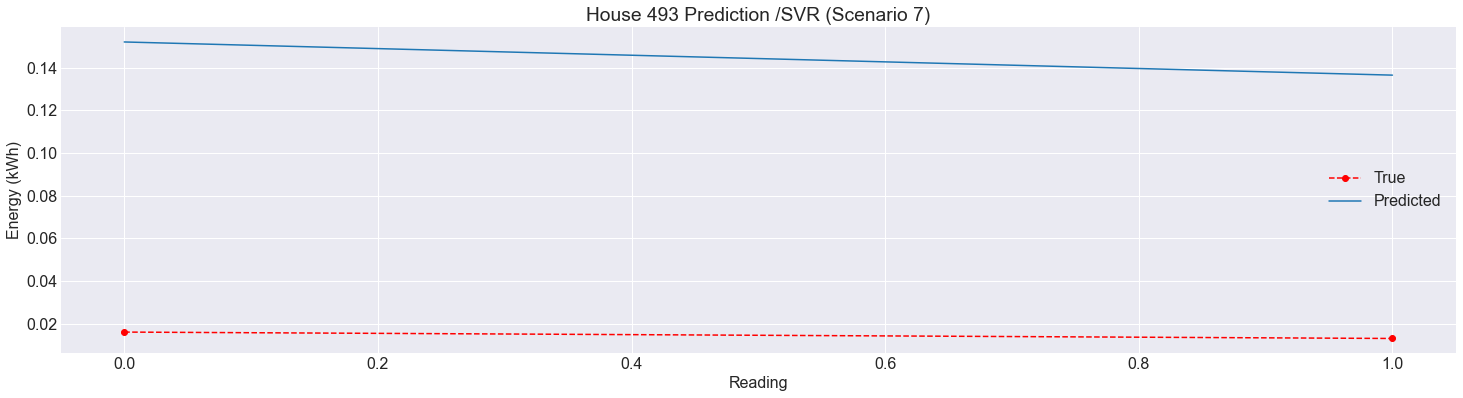

Mse:  0.014225532486612
Rmse: 0.119270836697878
Mae:  0.099931841578312
Mape:  29.086049989772267


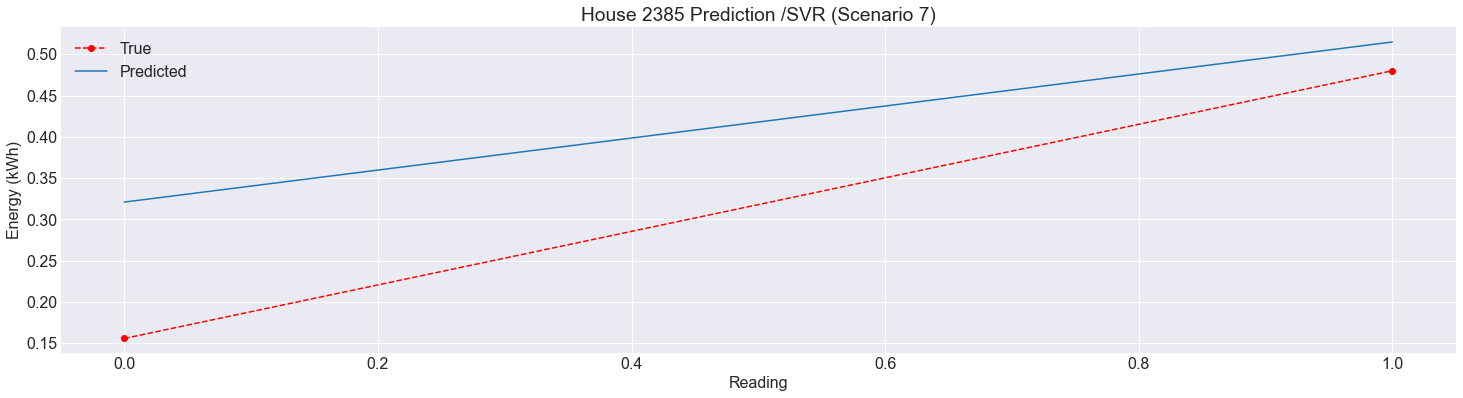

Mse:  0.010774174753267
Rmse: 0.103798722310380
Mae:  0.075203112582814
Mape:  34.791941523910573


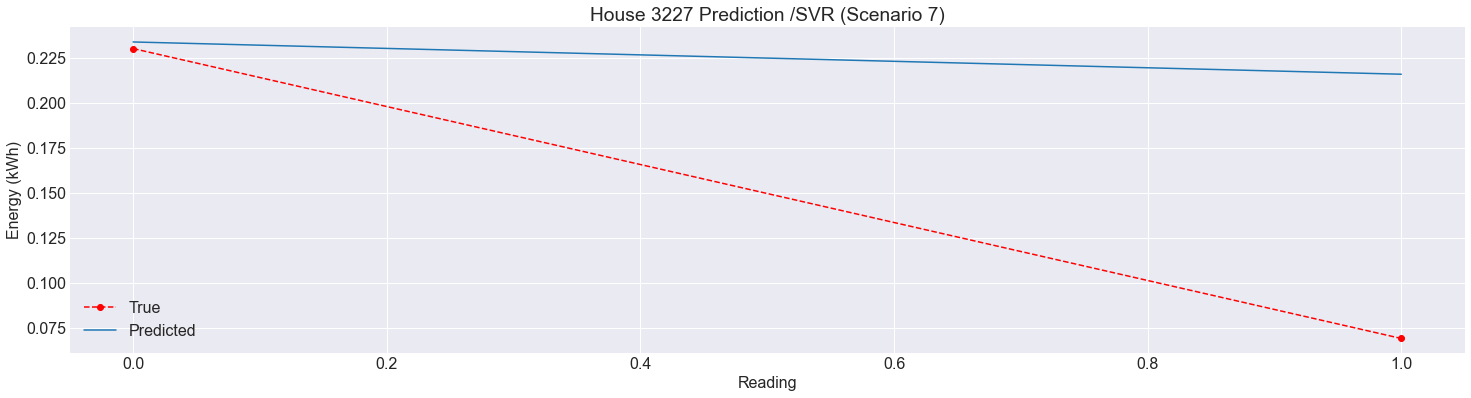

Mse:  0.058218843618190
Rmse: 0.241285813130798
Mae:  0.177264397869691
Mape:  107.441874045321953


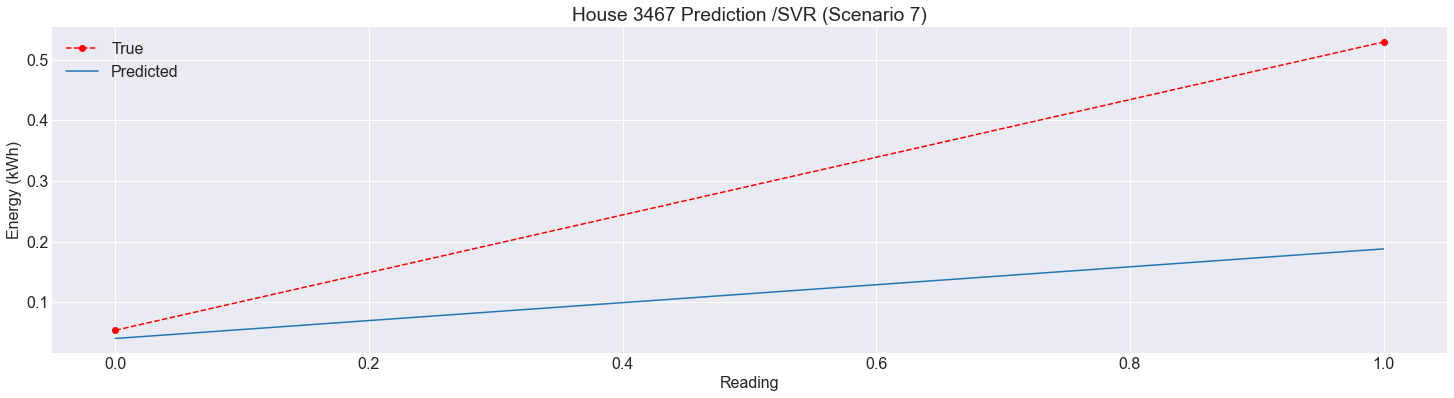

Mse:  0.032226783416214
Rmse: 0.179518198008485
Mae:  0.170414845599849
Mape:  59.453265583920043


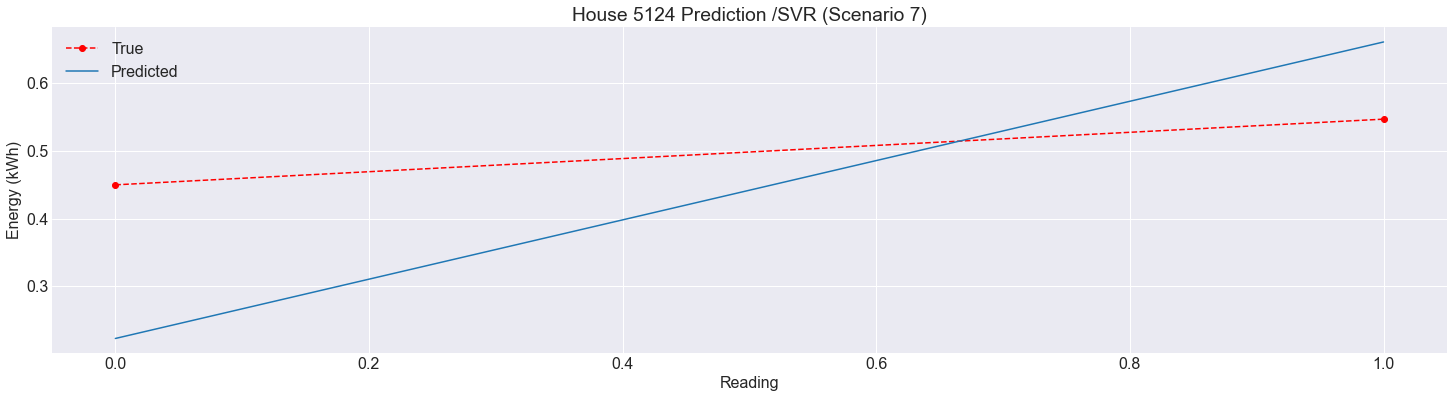

Mse:  0.000766062709612
Rmse: 0.027677837878200
Mae:  0.023751034166038
Mape:  7.261896439761419


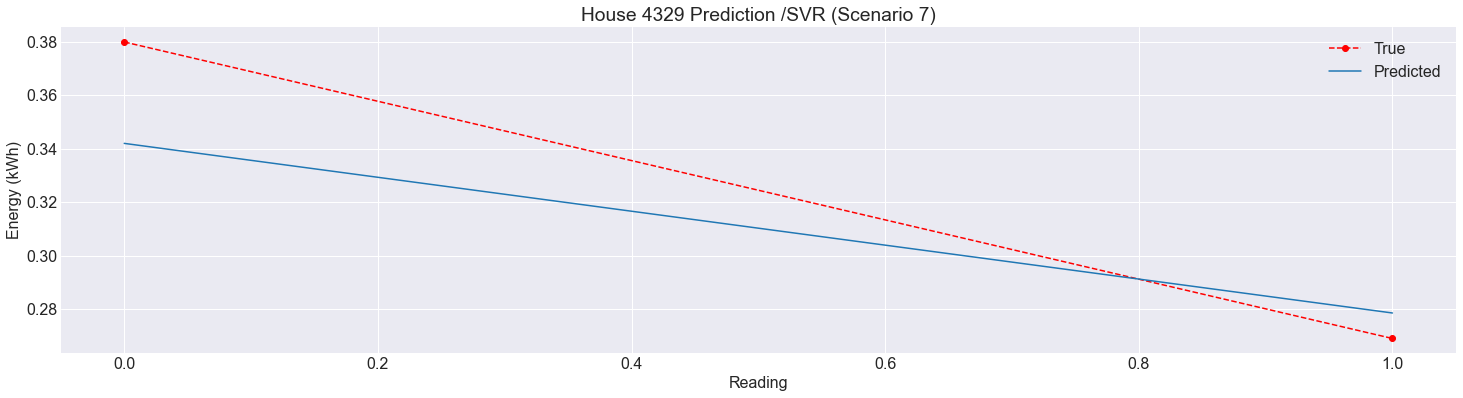

In [200]:
 ##### The households with an error have a '#' 

predict_household_AfterTuning(5492)
predict_household_AfterTuning(2)
predict_household_AfterTuning(3613)
predict_household_AfterTuning(4417)
predict_household_AfterTuning(4957)
predict_household_AfterTuning(3580)
predict_household_AfterTuning(2862)
predict_household_AfterTuning(4539)
predict_household_AfterTuning(336)
predict_household_AfterTuning(3957)
predict_household_AfterTuning(4059)
predict_household_AfterTuning(4151)
predict_household_AfterTuning(754)
predict_household_AfterTuning(1091)
predict_household_AfterTuning(4081)
predict_household_AfterTuning(3430)
predict_household_AfterTuning(3547)
predict_household_AfterTuning(885)
predict_household_AfterTuning(3245)
predict_household_AfterTuning(2883)
predict_household_AfterTuning(2657)
predict_household_AfterTuning(953)
predict_household_AfterTuning(2013)
predict_household_AfterTuning(493)
predict_household_AfterTuning(2385)
predict_household_AfterTuning(3227)
predict_household_AfterTuning(3467)
predict_household_AfterTuning(5124)
predict_household_AfterTuning(4329)

In [ ]:
models_performances_HH_level_Regression = pd.DataFrame([MSE_scores_HH, RMSE_scores_HH, MAE_scores_HH, MAPE_scores_HH],
                                   columns=households_predictions, 
                                   index=['MSE_scores', 'RMSE_scores',
                                          'MAE_scores', 'MAPE_scores'])
models_performances_HH_level_Regression

,HH_1,HH_2,HH_3,HH_4,HH_5,HH_6,HH_7,HH_8,HH_9,HH_10,...,HH_20,HH_21,HH_22,HH_23,HH_24,HH_25,HH_26,HH_27,HH_28,HH_29
MSE_scores,0.001527,0.006228,0.079347,0.008063,0.000199,0.001658,0.093868,0.002606,0.002847,0.013249,...,0.005379,0.010601,0.005574,0.003249,0.016880,0.014226,0.010774,0.058219,0.032227,0.000766
RMSE_scores,0.039072,0.078918,0.281686,0.089794,0.014102,0.040713,0.306380,0.051053,0.053355,0.115105,...,0.073342,0.102961,0.074661,0.056998,0.129923,0.119271,0.103799,0.241286,0.179518,0.027678
MAE_scores,0.030010,0.078295,0.267369,0.072850,0.011964,0.037835,0.280905,0.050843,0.048566,0.103857,...,0.072721,0.102165,0.073097,0.044831,0.129771,0.099932,0.075203,0.177264,0.170415,0.023751
MAPE_scores,20.239319,197.664411,44.038066,74.848141,23.718547,32.418971,71.246189,44.047225,38.808933,46.419387,...,24.198532,64.605668,57.933397,23.581383,89.976392,29.086050,34.791942,107.441874,59.453266,7.261896


In [ ]:
models_performances_HH_level_Regression.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/model_performance/models_performances_HH_level_Scenario3_1h_SVR.csv', index=False)